In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 생존율 데이터 읽기
df = pd.read_csv('/content/survival_ratio.csv', encoding='utf-8')

print("=== 1단계: 데이터 정제와 신뢰도 기반 분류 ===\n")

# 생존율 컬럼들 정의
survival_columns = [
    '24_1 1년', '24_1 3년', '24_1 5년',  # 1분기
    '24_2 1년', '24_2 3년', '24_2 5년',  # 2분기
    '24_3 1년', '24_3 3년', '24_3 5년',  # 3분기
    '24_4 1년', '24_4 3년', '24_4 5년'   # 4분기
]

def clean_survival_data(df):
    """생존율 데이터 정제 함수"""
    df_clean = df.copy()

    # 문자열 데이터를 숫자로 변환 (빈 문자열과 0은 NaN 처리)
    for col in survival_columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        # 0값도 실질적으로는 의미 있는 데이터이므로 유지하되, 분석시 구분해서 사용

    return df_clean

def calculate_data_quality_metrics(row):
    """각 업종별 데이터 품질 지표 계산"""
    survival_values = []

    # 모든 생존율 값들을 수집 (NaN 제외)
    for col in survival_columns:
        value = row[col]
        if pd.notna(value):
            survival_values.append(value)

    if len(survival_values) == 0:
        return {
            'valid_data_count': 0,
            'data_completeness': 0.0,
            'has_zero_survival': False,
            'avg_survival_rate': np.nan,
            'survival_consistency': np.nan,
            'logical_validity': True  # 데이터가 없으면 논리적 오류도 없음
        }

    # 1. 데이터 완성도: 전체 12개 컬럼 중 유효한 데이터 비율
    valid_count = len(survival_values)
    completeness = valid_count / len(survival_columns)

    # 2. 0% 생존율 포함 여부 (완전 실패 업종 식별)
    has_zero = 0.0 in survival_values

    # 3. 평균 생존율
    avg_survival = np.mean(survival_values)

    # 4. 생존율 일관성 (표준편차가 낮을수록 일관성 높음)
    consistency = np.std(survival_values) if len(survival_values) > 1 else 0

    # 5. 논리적 타당성 검사 (각 분기별로 1년≥3년≥5년 생존율 확인)
    logical_valid = True
    for quarter in ['24_1', '24_2', '24_3', '24_4']:
        year1 = row[f'{quarter} 1년']
        year3 = row[f'{quarter} 3년']
        year5 = row[f'{quarter} 5년']

        # 세 값이 모두 유효한 경우에만 논리성 검사
        if pd.notna(year1) and pd.notna(year3) and pd.notna(year5):
            if not (year1 >= year3 >= year5):
                logical_valid = False
                break

    return {
        'valid_data_count': valid_count,
        'data_completeness': completeness,
        'has_zero_survival': has_zero,
        'avg_survival_rate': avg_survival,
        'survival_consistency': consistency,
        'logical_validity': logical_valid
    }

# 데이터 정제
df_clean = clean_survival_data(df)

# 각 업종별 품질 지표 계산
quality_metrics = []

for idx, row in df_clean.iterrows():
    metrics = calculate_data_quality_metrics(row)

    quality_metrics.append({
        '학교': row['학교'],
        '업종_대': row['업종_대'],
        '업종_소': row['업종_소'],
        **metrics  # 품질 지표들 추가
    })

# 품질 지표 DataFrame 생성
quality_df = pd.DataFrame(quality_metrics)

print("=== 데이터 품질 지표별 분포 ===")
print(f"전체 업종 수: {len(quality_df)}")
print(f"유효 데이터 평균 개수: {quality_df['valid_data_count'].mean():.1f}/{len(survival_columns)}")
print(f"평균 완성도: {quality_df['data_completeness'].mean()*100:.1f}%")
print(f"논리적 오류 있는 업종: {len(quality_df[~quality_df['logical_validity']])}개")

# 신뢰도 기반 3단계 분류
def classify_reliability(row):
    """신뢰도 기반 분류 함수"""
    completeness = row['data_completeness']
    valid_count = row['valid_data_count']
    logical_valid = row['logical_validity']
    avg_survival = row['avg_survival_rate']

    # 논리적 오류가 있으면 무조건 저신뢰도
    if not logical_valid:
        return '저신뢰도'

    # 데이터가 너무 적으면 저신뢰도
    if valid_count < 3:
        return '저신뢰도'

    # 완성도와 데이터 개수를 종합해서 판단
    if completeness >= 0.5 and valid_count >= 6:  # 50% 이상 완성도, 6개 이상 데이터
        return '고신뢰도'
    elif completeness >= 0.25 and valid_count >= 4:  # 25% 이상 완성도, 4개 이상 데이터
        return '중신뢰도'
    else:
        return '저신뢰도'

# 신뢰도 분류 적용
quality_df['신뢰도등급'] = quality_df.apply(classify_reliability, axis=1)

print("\n=== 신뢰도 등급별 분포 ===")
reliability_dist = quality_df['신뢰도등급'].value_counts()
for grade, count in reliability_dist.items():
    percentage = count / len(quality_df) * 100
    print(f"{grade}: {count}개 ({percentage:.1f}%)")

print("\n=== 신뢰도 등급별 특성 ===")
for grade in ['고신뢰도', '중신뢰도', '저신뢰도']:
    grade_data = quality_df[quality_df['신뢰도등급'] == grade]
    if len(grade_data) > 0:
        print(f"\n[{grade}] - {len(grade_data)}개 업종")
        print(f"  평균 완성도: {grade_data['data_completeness'].mean()*100:.1f}%")
        print(f"  평균 유효데이터: {grade_data['valid_data_count'].mean():.1f}개")
        print(f"  평균 생존율: {grade_data['avg_survival_rate'].mean():.1f}%")

        # 업종_대별 분포
        industry_dist = grade_data['업종_대'].value_counts()
        print(f"  업종별 분포: {dict(industry_dist)}")

# 고신뢰도 업종들 상세 출력
print("\n=== 고신뢰도 업종 리스트 (추천 가능) ===")
high_reliability = quality_df[quality_df['신뢰도등급'] == '고신뢰도'].copy()
high_reliability = high_reliability.sort_values('avg_survival_rate', ascending=False)

if len(high_reliability) > 0:
    print(f"총 {len(high_reliability)}개 업종")
    for idx, row in high_reliability.iterrows():
        print(f"{row['업종_대']} > {row['업종_소']} "
              f"(평균 생존율: {row['avg_survival_rate']:.1f}%, "
              f"완성도: {row['data_completeness']*100:.0f}%, "
              f"대학: {row['학교']})")
else:
    print("고신뢰도 업종이 없습니다.")

# 중신뢰도 업종 중 유망한 것들
print("\n=== 중신뢰도 업종 중 유망한 후보들 (조건부 추천) ===")
medium_reliability = quality_df[quality_df['신뢰도등급'] == '중신뢰도'].copy()
medium_reliability = medium_reliability.sort_values('avg_survival_rate', ascending=False)

if len(medium_reliability) > 0:
    # 상위 10개만 출력
    top_medium = medium_reliability.head(10)
    for idx, row in top_medium.iterrows():
        print(f"{row['업종_대']} > {row['업종_소']} "
              f"(평균 생존율: {row['avg_survival_rate']:.1f}%, "
              f"완성도: {row['data_completeness']*100:.0f}%, "
              f"대학: {row['학교']})")

# 결과 저장
quality_df.to_csv('업종별_데이터품질_분석.csv', index=False, encoding='utf-8')
print(f"\n분석 결과가 '업종별_데이터품질_분석.csv'에 저장되었습니다.")

# 요약 통계
print("\n=== 최종 요약 ===")
print(f"• 전체 {len(quality_df)}개 업종 중")
print(f"• 고신뢰도: {len(quality_df[quality_df['신뢰도등급'] == '고신뢰도'])}개 (강력 추천 가능)")
print(f"• 중신뢰도: {len(quality_df[quality_df['신뢰도등급'] == '중신뢰도'])}개 (조건부 추천)")
print(f"• 저신뢰도: {len(quality_df[quality_df['신뢰도등급'] == '저신뢰도'])}개 (추천 비권장)")

=== 1단계: 데이터 정제와 신뢰도 기반 분류 ===

=== 데이터 품질 지표별 분포 ===
전체 업종 수: 372
유효 데이터 평균 개수: 7.2/12
평균 완성도: 60.2%
논리적 오류 있는 업종: 95개

=== 신뢰도 등급별 분포 ===
저신뢰도: 242개 (65.1%)
고신뢰도: 130개 (34.9%)

=== 신뢰도 등급별 특성 ===

[고신뢰도] - 130개 업종
  평균 완성도: 95.3%
  평균 유효데이터: 11.4개
  평균 생존율: 14.9%
  업종별 분포: {'소매업': np.int64(56), '음식업': np.int64(38), '서비스업': np.int64(36)}

[저신뢰도] - 242개 업종
  평균 완성도: 41.4%
  평균 유효데이터: 5.0개
  평균 생존율: 22.5%
  업종별 분포: {'소매업': np.int64(128), '서비스업': np.int64(84), '음식업': np.int64(30)}

=== 고신뢰도 업종 리스트 (추천 가능) ===
총 130개 업종
서비스업 > 두발 미용 (평균 생존율: 75.0%, 완성도: 100%, 대학: 명지대)
서비스업 > 자동차 세차 (평균 생존율: 62.5%, 완성도: 100%, 대학: 용인대)
음식업 > 패스트푸드점 (평균 생존율: 61.2%, 완성도: 100%, 대학: 경희대)
서비스업 > 미술학원 (평균 생존율: 60.4%, 완성도: 100%, 대학: 명지대)
음식업 > 생맥주 전문점 (평균 생존율: 59.6%, 완성도: 100%, 대학: 경희대)
음식업 > 기타 주점업 (평균 생존율: 59.4%, 완성도: 100%, 대학: 명지대)
음식업 > 치킨전문점 (평균 생존율: 59.4%, 완성도: 100%, 대학: 명지대)
음식업 > 한식 육류요리 전문점 (평균 생존율: 59.0%, 완성도: 100%, 대학: 명지대)
음식업 > 커피 전문점 (평균 생존율: 57.3%, 완성도: 100%, 대학: 명지대)
서비스업 > 태권도, 무술학원 (평균 생존율: 56.4%

=== 2단계: 다각도 생존율 지표 개발 ===

종합 지표 계산 중...
분석 가능한 업종: 258개 (전체 372개 중)

=== 다각도 생존율 지표 분석 결과 ===

▶ 종합 추천 순위 TOP 15
 1. 서비스업 > 두발 미용 (명지대)
    종합점수: 88.5
    성과: 100 | 안정성: 93 | 트렌드: 48 | 안전성: 100
    원시데이터 - 전반성과: 71.4% | 트렌드: -274.00%/분기 | 리스크: 0.0

 2. 서비스업 > 자동차 세차 (용인대)
    종합점수: 86.9
    성과: 88 | 안정성: 94 | 트렌드: 64 | 안전성: 100
    원시데이터 - 전반성과: 62.5% | 트렌드: 501.00%/분기 | 리스크: 0.0

 3. 음식업 > 치킨전문점 (명지대)
    종합점수: 77.3
    성과: 74 | 안정성: 82 | 트렌드: 73 | 안전성: 100
    원시데이터 - 전반성과: 53.0% | 트렌드: 957.33%/분기 | 리스크: 0.0

 4. 서비스업 > 피부 미용 (경희대)
    종합점수: 77.3
    성과: 94 | 안정성: 77 | 트렌드: 65 | 안전성: 52
    원시데이터 - 전반성과: 67.2% | 트렌드: 558.00%/분기 | 리스크: 38.3

 5. 음식업 > 기타 주점업 (명지대)
    종합점수: 77.2
    성과: 74 | 안정성: 86 | 트렌드: 53 | 안전성: 100
    원시데이터 - 전반성과: 53.1% | 트렌드: -27.00%/분기 | 리스크: 0.0

 6. 음식업 > 패스트푸드점 (경희대)
    종합점수: 77.2
    성과: 76 | 안정성: 84 | 트렌드: 65 | 안전성: 100
    원시데이터 - 전반성과: 54.1% | 트렌드: 534.00%/분기 | 리스크: 0.0

 7. 서비스업 > 일반 교과학원 (경희대)
    종합점수: 76.3
    성과: 95 | 안정성: 82 | 트렌드: 51 | 안전성: 5

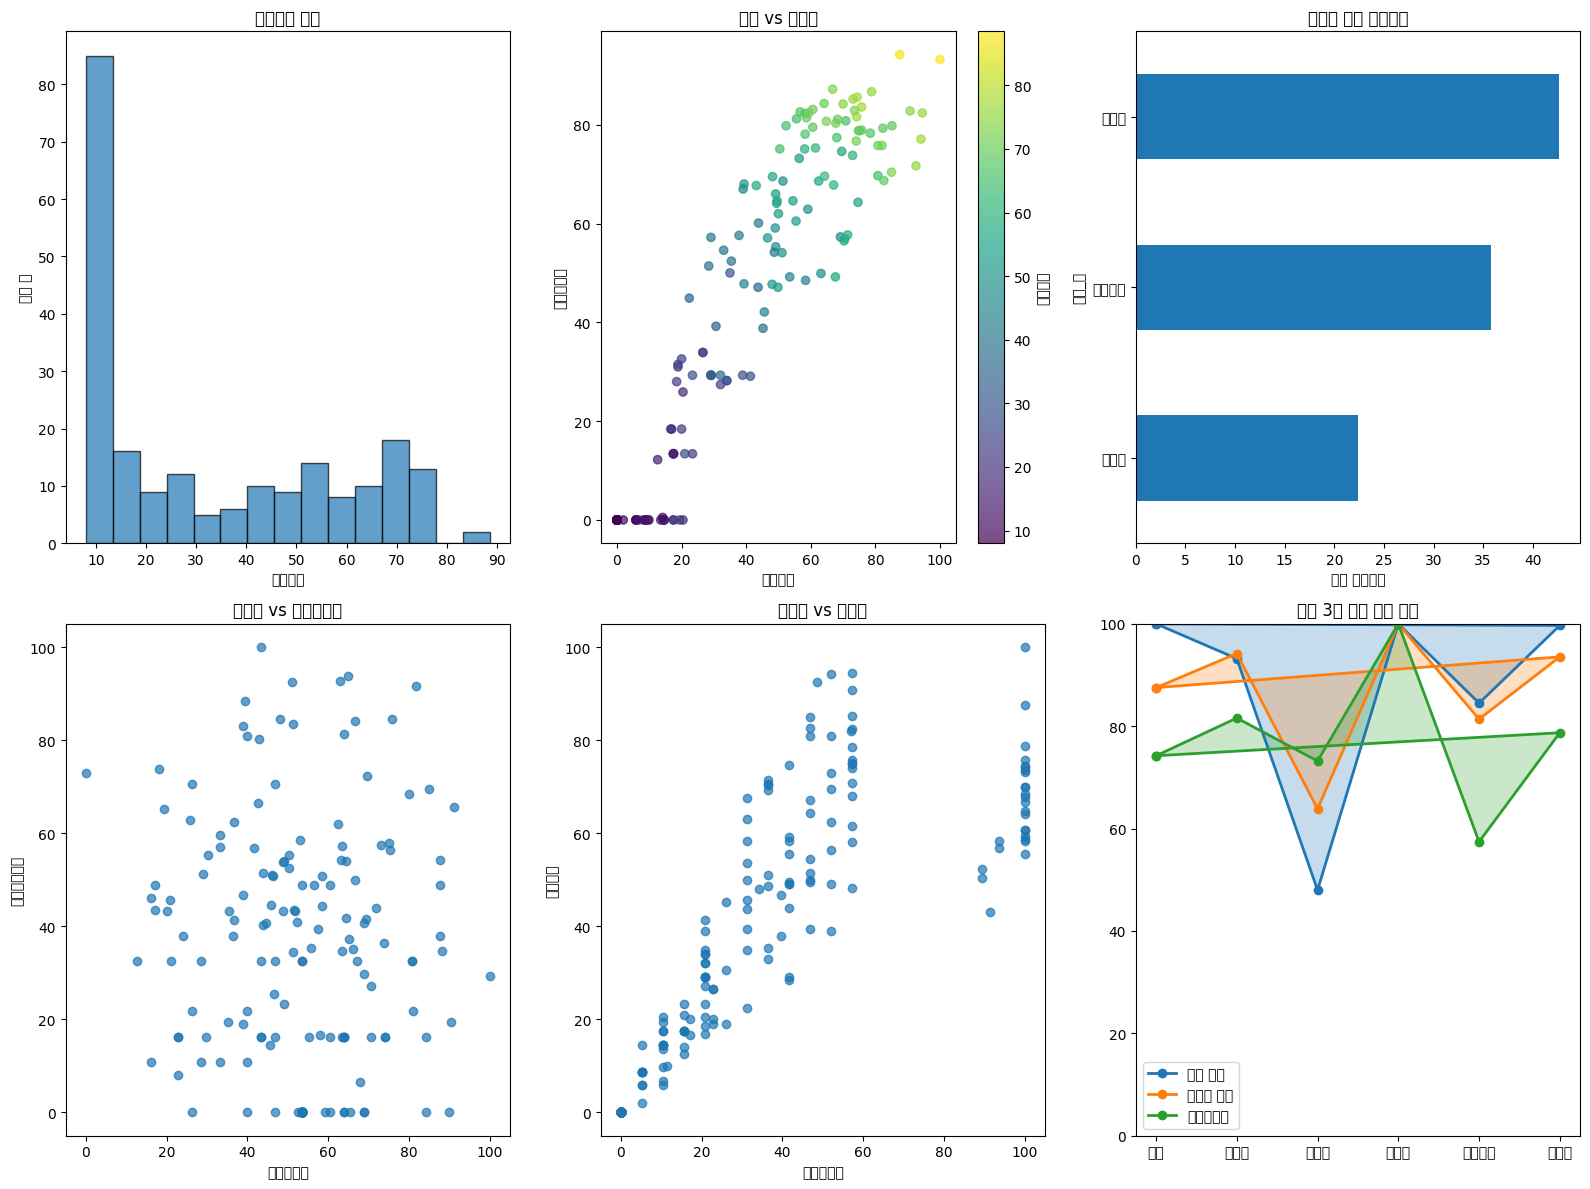


✅ 분석 완료!
• 총 258개 업종 분석
• 결과 파일: '다각도_생존율_분석결과.csv'
• 시각화 파일: '다각도_생존율_분석_시각화.png'
• 6개 지표를 종합한 맞춤형 추천 시스템 구축 완료


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
import matplotlib.font_manager as fm
font_list = [f.name for f in fm.fontManager.ttflist if 'Gothic' in f.name or 'Nanum' in f.name or 'Malgun' in f.name]
if font_list:
    plt.rcParams['font.family'] = font_list[0]
else:
    plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("=== 2단계: 다각도 생존율 지표 개발 ===\n")

# 1단계에서 정제된 데이터 불러오기 (실제로는 1단계 결과를 사용)
# 여기서는 샘플 구조로 시연
df = pd.read_csv('survival_ratio.csv', encoding='utf-8')

# 생존율 컬럼들 재정의
survival_columns = [
    '24_1 1년', '24_1 3년', '24_1 5년',
    '24_2 1년', '24_2 3년', '24_2 5년',
    '24_3 1년', '24_3 3년', '24_3 5년',
    '24_4 1년', '24_4 3년', '24_4 5년'
]

# 데이터 정제
for col in survival_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

def calculate_comprehensive_metrics(row):
    """
    종합적인 생존율 지표 계산 함수
    각 업종에 대해 6개의 서로 다른 관점에서 평가
    """

    # 각 시기별 데이터 추출
    quarters = ['24_1', '24_2', '24_3', '24_4']
    periods = ['1년', '3년', '5년']

    # 유효한 데이터만 추출
    all_values = []
    year1_values = []
    year3_values = []
    year5_values = []
    quarterly_averages = []

    for quarter in quarters:
        quarter_values = []
        for period in periods:
            col_name = f'{quarter} {period}'
            value = row[col_name]
            if pd.notna(value):
                all_values.append(value)
                quarter_values.append(value)

                # 기간별로 분류
                if period == '1년':
                    year1_values.append(value)
                elif period == '3년':
                    year3_values.append(value)
                else:  # 5년
                    year5_values.append(value)

        # 분기별 평균 계산 (해당 분기에 데이터가 있는 경우만)
        if quarter_values:
            quarterly_averages.append(np.mean(quarter_values))

    # 데이터가 부족한 경우 기본값 반환
    if len(all_values) < 3:
        return {
            'data_sufficient': False,
            'overall_performance': np.nan,
            'stability_score': np.nan,
            'trend_direction': np.nan,
            'risk_level': np.nan,
            'long_term_viability': np.nan,
            'consistency_score': np.nan
        }

    # === 지표 1: 전반적 성과 점수 ===
    # 모든 유효한 생존율의 가중평균 (장기 생존율에 더 높은 가중치)
    weighted_sum = 0
    weight_sum = 0

    for quarter in quarters:
        year1 = row[f'{quarter} 1년']
        year3 = row[f'{quarter} 3년']
        year5 = row[f'{quarter} 5년']

        if pd.notna(year1):
            weighted_sum += year1 * 1.0  # 1년 생존율 가중치
            weight_sum += 1.0
        if pd.notna(year3):
            weighted_sum += year3 * 2.0  # 3년 생존율 가중치
            weight_sum += 2.0
        if pd.notna(year5):
            weighted_sum += year5 * 3.0  # 5년 생존율 가중치
            weight_sum += 3.0

    overall_performance = weighted_sum / weight_sum if weight_sum > 0 else np.nan

    # === 지표 2: 안정성 점수 ===
    # 생존율의 변동성이 낮을수록 높은 점수
    if len(all_values) > 1:
        cv = np.std(all_values) / np.mean(all_values) if np.mean(all_values) > 0 else float('inf')
        stability_score = max(0, 100 - cv * 50)  # 변동계수에 반비례하는 점수
    else:
        stability_score = np.nan

    # === 지표 3: 트렌드 방향성 ===
    # 분기별 평균 생존율의 추세 분석
    if len(quarterly_averages) >= 3:
        # 선형 회귀로 추세 기울기 계산
        x = np.arange(len(quarterly_averages))
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, quarterly_averages)
        trend_direction = slope * 100  # 분기당 생존율 변화율(%)
    else:
        trend_direction = np.nan

    # === 지표 4: 리스크 수준 ===
    # 0% 생존율 빈도와 최저 생존율을 종합한 위험도
    zero_count = sum(1 for v in all_values if v == 0)
    min_survival = min(all_values)

    # 0% 빈도 패널티 + 최저점 패널티
    zero_penalty = zero_count / len(all_values) * 50
    min_penalty = max(0, (20 - min_survival)) / 20 * 30
    risk_level = zero_penalty + min_penalty

    # === 지표 5: 장기 생존 가능성 ===
    # 5년 생존율이 있는 경우 이를 중심으로, 없으면 3년 생존율 활용
    if year5_values:
        long_term_viability = np.mean(year5_values)
    elif year3_values:
        long_term_viability = np.mean(year3_values) * 0.8  # 3년 데이터는 약간 할인
    else:
        long_term_viability = np.mean(year1_values) * 0.6  # 1년 데이터는 더 많이 할인

    # === 지표 6: 일관성 점수 ===
    # 같은 기간 내에서 분기별 생존율의 일관성 측정
    consistency_scores = []

    for period in periods:
        period_values = []
        for quarter in quarters:
            value = row[f'{quarter} {period}']
            if pd.notna(value):
                period_values.append(value)

        if len(period_values) >= 2:
            period_consistency = 100 - (np.std(period_values) / np.mean(period_values) * 100 if np.mean(period_values) > 0 else 100)
            consistency_scores.append(max(0, period_consistency))

    consistency_score = np.mean(consistency_scores) if consistency_scores else np.nan

    return {
        'data_sufficient': True,
        'overall_performance': round(overall_performance, 1),
        'stability_score': round(stability_score, 1),
        'trend_direction': round(trend_direction, 2),
        'risk_level': round(risk_level, 1),
        'long_term_viability': round(long_term_viability, 1),
        'consistency_score': round(consistency_score, 1)
    }

# 모든 업종에 대해 종합 지표 계산
comprehensive_results = []

print("종합 지표 계산 중...")
for idx, row in df.iterrows():
    metrics = calculate_comprehensive_metrics(row)

    result = {
        '학교': row['학교'],
        '업종_대': row['업종_대'],
        '업종_소': row['업종_소'],
        **metrics
    }
    comprehensive_results.append(result)

# 결과 DataFrame 생성
results_df = pd.DataFrame(comprehensive_results)

# 데이터가 충분한 업종만 필터링
sufficient_data = results_df[results_df['data_sufficient'] == True].copy()

print(f"분석 가능한 업종: {len(sufficient_data)}개 (전체 {len(results_df)}개 중)")

if len(sufficient_data) == 0:
    print("분석 가능한 데이터가 부족합니다.")
else:
    # === 종합 점수 계산 ===
    # 각 지표를 0-100 점수로 정규화 후 가중평균

    def normalize_to_100(series, reverse=False):
        """시리즈를 0-100 점수로 정규화"""
        if series.isna().all():
            return series

        min_val = series.min()
        max_val = series.max()

        if max_val == min_val:
            return pd.Series([50] * len(series), index=series.index)

        if reverse:  # 낮을수록 좋은 지표 (예: 리스크)
            normalized = 100 - ((series - min_val) / (max_val - min_val)) * 100
        else:  # 높을수록 좋은 지표
            normalized = ((series - min_val) / (max_val - min_val)) * 100

        return normalized

    # 각 지표 정규화
    sufficient_data['성과점수'] = normalize_to_100(sufficient_data['overall_performance'])
    sufficient_data['안정성점수'] = normalize_to_100(sufficient_data['stability_score'])
    sufficient_data['트렌드점수'] = normalize_to_100(sufficient_data['trend_direction'])
    sufficient_data['안전성점수'] = normalize_to_100(sufficient_data['risk_level'], reverse=True)
    sufficient_data['장기전망점수'] = normalize_to_100(sufficient_data['long_term_viability'])
    sufficient_data['일관성점수'] = normalize_to_100(sufficient_data['consistency_score'])

    # 가중 종합 점수 계산
    weights = {
        '성과점수': 0.25,      # 전반적 성과
        '안정성점수': 0.20,    # 안정성
        '트렌드점수': 0.15,    # 성장 추세
        '안전성점수': 0.15,    # 리스크 관리
        '장기전망점수': 0.15,  # 장기 생존가능성
        '일관성점수': 0.10     # 예측가능성
    }

    sufficient_data['종합점수'] = 0
    for metric, weight in weights.items():
        sufficient_data['종합점수'] += sufficient_data[metric] * weight

    sufficient_data['종합점수'] = sufficient_data['종합점수'].round(1)

    # === 결과 분석 및 출력 ===
    print("\n=== 다각도 생존율 지표 분석 결과 ===")

    # 상위 추천 업종 (종합점수 기준)
    top_industries = sufficient_data.nlargest(15, '종합점수')

    print(f"\n▶ 종합 추천 순위 TOP 15")
    print("="*80)
    for idx, (_, row) in enumerate(top_industries.iterrows(), 1):
        print(f"{idx:2d}. {row['업종_대']} > {row['업종_소']} ({row['학교']})")
        print(f"    종합점수: {row['종합점수']:.1f}")
        print(f"    성과: {row['성과점수']:.0f} | 안정성: {row['안정성점수']:.0f} | " +
              f"트렌드: {row['트렌드점수']:.0f} | 안전성: {row['안전성점수']:.0f}")
        print(f"    원시데이터 - 전반성과: {row['overall_performance']:.1f}% | " +
              f"트렌드: {row['trend_direction']:.2f}%/분기 | 리스크: {row['risk_level']:.1f}")
        print()

    # 특성별 최고 업종들
    print("\n▶ 특성별 최고 업종")
    print("="*60)

    characteristics = [
        ('가장 안정적인', '안정성점수', '높은 안정성으로 예측 가능한 수익'),
        ('가장 성장중인', '트렌드점수', '상승 추세로 미래 전망이 밝음'),
        ('가장 안전한', '안전성점수', '실패 위험이 낮아 안전한 투자'),
        ('장기 생존력 최고', '장기전망점수', '5년 이상 장기간 생존 가능성이 높음')
    ]

    for char_name, metric, description in characteristics:
        best = sufficient_data.loc[sufficient_data[metric].idxmax()]
        print(f"{char_name}: {best['업종_대']} > {best['업종_소']} ({best['학교']})")
        print(f"  → {description}")
        print(f"  → {metric}: {best[metric]:.1f}점 (원시값: {best[metric.replace('점수', '').replace('안전성', 'risk_level').replace('장기전망', 'long_term_viability').replace('트렌드', 'trend_direction').replace('안정성', 'stability_score')]:.1f})")
        print()

    # 업종 대분류별 평균 성과
    print("\n▶ 업종 대분류별 평균 성과")
    print("="*50)
    industry_summary = sufficient_data.groupby('업종_대').agg({
        '종합점수': 'mean',
        '성과점수': 'mean',
        '안정성점수': 'mean',
        '트렌드점수': 'mean',
        '업종_소': 'count'
    }).round(1)
    industry_summary.columns = ['종합점수', '성과', '안정성', '트렌드', '분석업종수']
    industry_summary = industry_summary.sort_values('종합점수', ascending=False)

    print(industry_summary)

    # 결과 저장
    sufficient_data.to_csv('다각도_생존율_분석결과.csv', index=False, encoding='utf-8')

    # 시각화
    plt.figure(figsize=(16, 12))

    # 1. 종합점수 분포
    plt.subplot(2, 3, 1)
    plt.hist(sufficient_data['종합점수'], bins=15, alpha=0.7, edgecolor='black')
    plt.title('종합점수 분포')
    plt.xlabel('종합점수')
    plt.ylabel('업종 수')

    # 2. 성과 vs 안정성 산점도
    plt.subplot(2, 3, 2)
    scatter = plt.scatter(sufficient_data['성과점수'], sufficient_data['안정성점수'],
                         c=sufficient_data['종합점수'], cmap='viridis', alpha=0.7)
    plt.xlabel('성과점수')
    plt.ylabel('안정성점수')
    plt.title('성과 vs 안정성')
    plt.colorbar(scatter, label='종합점수')

    # 3. 업종대별 평균 점수
    plt.subplot(2, 3, 3)
    industry_avg = sufficient_data.groupby('업종_대')['종합점수'].mean().sort_values()
    industry_avg.plot(kind='barh')
    plt.title('업종별 평균 종합점수')
    plt.xlabel('평균 종합점수')

    # 4. 트렌드 vs 장기전망
    plt.subplot(2, 3, 4)
    plt.scatter(sufficient_data['트렌드점수'], sufficient_data['장기전망점수'], alpha=0.7)
    plt.xlabel('트렌드점수')
    plt.ylabel('장기전망점수')
    plt.title('성장성 vs 지속가능성')

    # 5. 리스크 vs 수익률
    plt.subplot(2, 3, 5)
    plt.scatter(sufficient_data['안전성점수'], sufficient_data['성과점수'], alpha=0.7)
    plt.xlabel('안전성점수')
    plt.ylabel('성과점수')
    plt.title('안전성 vs 수익성')

    # 6. 6개 지표 레이더 차트 (상위 업종)
    plt.subplot(2, 3, 6)
    top_3 = sufficient_data.nlargest(3, '종합점수')
    metrics = ['성과점수', '안정성점수', '트렌드점수', '안전성점수', '장기전망점수', '일관성점수']

    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

    for idx, (_, row) in enumerate(top_3.iterrows()):
        values = [row[metric] for metric in metrics]
        values += [values[0]]
        plt.plot(angles, values, 'o-', linewidth=2, label=f"{row['업종_소']}")
        plt.fill(angles, values, alpha=0.25)

    plt.xticks(angles[:-1], [m.replace('점수', '') for m in metrics])
    plt.ylim(0, 100)
    plt.title('상위 3개 업종 특성 비교')
    plt.legend()

    plt.tight_layout()
    plt.savefig('다각도_생존율_분석_시각화.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✅ 분석 완료!")
    print(f"• 총 {len(sufficient_data)}개 업종 분석")
    print(f"• 결과 파일: '다각도_생존율_분석결과.csv'")
    print(f"• 시각화 파일: '다각도_생존율_분석_시각화.png'")
    print(f"• 6개 지표를 종합한 맞춤형 추천 시스템 구축 완료")

In [3]:
# 예시: 두 유사도 DataFrame (경희대 기준) 있다고 가정
# market_sim, demo_sim (index=학교, value=유사도 0~1)
market_sim = pd.Series({'경기대' : 0.944,'단국대':0.775,'명지대':0.869,'용인대':0.714,'성균관대':0.685,'수원대':0.659,'아주대' : 0.816})
demo_sim   = pd.Series({'경기대' : -0.284, '단국대':0.538,'명지대':0.508,'용인대':0.438,'성균관대':0.313,'수원대':-0.620,'아주대' : -0.698})

# 가중 평균
alpha = 0.3  # 상권 가중치
final_sim = alpha*market_sim + (1-alpha)*demo_sim

print(final_sim.sort_values(ascending=False))

명지대     0.6163
단국대     0.6091
용인대     0.5208
성균관대    0.4246
경기대     0.0844
수원대    -0.2363
아주대    -0.2438
dtype: float64


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

print("=== 저신뢰도 데이터 대체 시스템 ===\n")

class UniversityAreaDataImputation:
    """
    대학가별 유사도를 기반으로 저신뢰도 데이터를 고신뢰도 데이터로 대체하는 클래스

    핵심 아이디어:
    1. 각 대학가의 특성을 수치화하여 유사도 계산
    2. 유사한 대학가들의 고신뢰도 데이터를 활용하여 저신뢰도 데이터 대체
    3. 대체된 데이터에는 신뢰도 페널티 적용
    """

    def __init__(self):
        self.university_profiles = {}  # 대학가별 특성 프로필
        self.similarity_matrix = None  # 대학가 간 유사도 매트릭스
        self.scaler = StandardScaler()

    def create_university_profiles(self, df):
        """
        각 대학가의 특성을 수치화하여 프로필 생성

        실제 구현에서는 다음과 같은 외부 데이터가 필요:
        - 학생 수, 대학 유형(종합대/전문대), 지역 특성, 상권 밀도 등

        현재는 데이터에서 추출 가능한 정보로 대체 구현
        """
        print("대학가 특성 프로필 생성 중...")

        for university in df['학교'].unique():
            univ_data = df[df['학교'] == university]

            # 현재 데이터에서 추출 가능한 특성들
            profile = {
                'total_industries': len(univ_data),  # 총 업종 수 (상권 규모 추정)
                'retail_ratio': len(univ_data[univ_data['업종_대'] == '소매업']) / len(univ_data),
                'service_ratio': len(univ_data[univ_data['업종_대'] == '서비스업']) / len(univ_data),
                'food_ratio': len(univ_data[univ_data['업종_대'] == '음식업']) / len(univ_data),
                'data_quality': self._calculate_overall_data_quality(univ_data)
            }

            # 실제 구현에서는 여기에 외부 데이터 추가
            # profile['student_count'] = external_data[university]['students']
            # profile['regional_income'] = external_data[university]['income']
            # profile['commercial_density'] = external_data[university]['density']

            self.university_profiles[university] = profile

        print(f"총 {len(self.university_profiles)}개 대학가 프로필 생성 완료\n")

        # 프로필 내용 출력
        for univ, profile in self.university_profiles.items():
            print(f"{univ}: 업종수 {profile['total_industries']}, " +
                  f"소매업 {profile['retail_ratio']:.2f}, " +
                  f"서비스업 {profile['service_ratio']:.2f}, " +
                  f"음식업 {profile['food_ratio']:.2f}, " +
                  f"데이터품질 {profile['data_quality']:.2f}")

    def _calculate_overall_data_quality(self, univ_data):
        """특정 대학가의 전체적인 데이터 품질 점수 계산"""
        survival_columns = [
            '24_1 1년', '24_1 3년', '24_1 5년',
            '24_2 1년', '24_2 3년', '24_2 5년',
            '24_3 1년', '24_3 3년', '24_3 5년',
            '24_4 1년', '24_4 3년', '24_4 5년'
        ]

        total_possible = len(univ_data) * len(survival_columns)
        total_valid = 0

        for _, row in univ_data.iterrows():
            for col in survival_columns:
                if pd.notna(row[col]) and str(row[col]).strip() != '':
                    total_valid += 1

        return total_valid / total_possible if total_possible > 0 else 0

    def calculate_similarity_matrix(self):
        """
        모든 대학가 간의 유사도 매트릭스 계산
        코사인 유사도를 사용하여 대학가 특성의 유사성 측정
        """
        print("대학가 간 유사도 매트릭스 계산 중...")

        universities = list(self.university_profiles.keys())

        # 특성 데이터를 매트릭스 형태로 변환
        feature_matrix = []
        for univ in universities:
            profile = self.university_profiles[univ]
            features = [
                profile['total_industries'],
                profile['retail_ratio'],
                profile['service_ratio'],
                profile['food_ratio'],
                profile['data_quality']
            ]
            feature_matrix.append(features)

        # 표준화 적용 (각 특성의 스케일을 맞춤)
        feature_matrix = self.scaler.fit_transform(feature_matrix)

        # 코사인 유사도 계산
        self.similarity_matrix = cosine_similarity(feature_matrix)

        # 결과를 DataFrame으로 변환 (가독성을 위해)
        similarity_df = pd.DataFrame(
            self.similarity_matrix,
            index=universities,
            columns=universities
        )

        print("유사도 매트릭스 계산 완료\n")
        print("=== 대학가 간 유사도 (상위 유사 대학 쌍) ===")

        # 가장 유사한 대학 쌍들 출력 (자기 자신 제외)
        similarity_pairs = []
        for i, univ1 in enumerate(universities):
            for j, univ2 in enumerate(universities):
                if i < j:  # 중복 제거
                    similarity_pairs.append((
                        univ1, univ2, self.similarity_matrix[i][j]
                    ))

        similarity_pairs.sort(key=lambda x: x[2], reverse=True)
        for univ1, univ2, sim_score in similarity_pairs[:5]:
            print(f"{univ1} ↔ {univ2}: {sim_score:.3f}")

        return similarity_df

    def find_similar_universities(self, target_university, min_similarity=0.3, max_candidates=3):
        """
        특정 대학교와 유사한 대학교들을 찾아 반환

        Parameters:
        - target_university: 대상 대학교명
        - min_similarity: 최소 유사도 기준 (이 값 이상인 대학만 고려)
        - max_candidates: 최대 후보 대학 수
        """
        if self.similarity_matrix is None:
            raise ValueError("유사도 매트릭스가 계산되지 않았습니다. calculate_similarity_matrix()를 먼저 실행하세요.")

        universities = list(self.university_profiles.keys())
        target_idx = universities.index(target_university)

        # 대상 대학과 다른 대학들 간의 유사도 추출
        similarities = []
        for i, univ in enumerate(universities):
            if i != target_idx:  # 자기 자신 제외
                sim_score = self.similarity_matrix[target_idx][i]
                if sim_score >= min_similarity:
                    similarities.append((univ, sim_score))

        # 유사도 순으로 정렬하여 상위 후보들 반환
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:max_candidates]

    def impute_low_reliability_data(self, df_with_reliability):
        """
        저신뢰도 데이터를 유사한 대학가의 고신뢰도 데이터로 대체

        Process:
        1. 저신뢰도 업종 식별
        2. 해당 업종과 동일한 업종의 고신뢰도 데이터를 유사 대학에서 찾기
        3. 가중평균으로 대체값 계산
        4. 대체 정보 기록
        """
        print("\n=== 저신뢰도 데이터 대체 프로세스 시작 ===")

        # 결과를 저장할 새로운 DataFrame 생성
        df_imputed = df_with_reliability.copy()

        # 대체 정보를 기록할 컬럼들 추가
        df_imputed['data_imputed'] = False  # 데이터가 대체되었는지 여부
        df_imputed['imputation_source'] = ''  # 어느 대학들에서 대체했는지
        df_imputed['original_reliability'] = df_imputed['신뢰도등급']  # 원본 신뢰도 보존

        survival_columns = [
            '24_1 1년', '24_1 3년', '24_1 5년',
            '24_2 1년', '24_2 3년', '24_2 5년',
            '24_3 1년', '24_3 3년', '24_3 5년',
            '24_4 1년', '24_4 3년', '24_4 5년'
        ]

        imputation_count = 0
        successful_imputation = 0

        # 저신뢰도 업종들에 대해 대체 수행
        low_reliability_mask = df_imputed['신뢰도등급'] == '저신뢰도'
        low_reliability_industries = df_imputed[low_reliability_mask]

        print(f"대체 대상: {len(low_reliability_industries)}개 저신뢰도 업종")

        for idx, row in low_reliability_industries.iterrows():
            target_university = row['학교']
            target_major_industry = row['업종_대']
            target_minor_industry = row['업종_소']

            try:
                # 유사한 대학교들 찾기
                similar_universities = self.find_similar_universities(target_university)

                if not similar_universities:
                    print(f"  {target_university} - {target_major_industry}>{target_minor_industry}: 유사 대학 없음")
                    continue

                # 동일한 업종의 고신뢰도 데이터 찾기
                replacement_values = []
                source_universities = []

                for similar_univ, similarity_score in similar_universities:
                    # 유사 대학에서 동일 업종의 고신뢰도 데이터 찾기
                    similar_industry_data = df_imputed[
                        (df_imputed['학교'] == similar_univ) &
                        (df_imputed['업종_대'] == target_major_industry) &
                        (df_imputed['업종_소'] == target_minor_industry) &
                        (df_imputed['신뢰도등급'] == '고신뢰도')
                    ]

                    if len(similar_industry_data) > 0:
                        # 해당 업종의 생존율 데이터 추출
                        similar_row = similar_industry_data.iloc[0]
                        industry_values = []

                        for col in survival_columns:
                            value = similar_row[col]
                            if pd.notna(value) and str(value).strip() != '':
                                try:
                                    industry_values.append(float(value))
                                except ValueError:
                                    continue

                        if industry_values:  # 유효한 데이터가 있는 경우
                            avg_value = np.mean(industry_values)
                            replacement_values.append((avg_value, similarity_score))
                            source_universities.append(similar_univ)

                # 대체값 계산 (유사도 가중평균)
                if replacement_values:
                    weighted_sum = sum(value * weight for value, weight in replacement_values)
                    total_weight = sum(weight for _, weight in replacement_values)
                    final_replacement_value = weighted_sum / total_weight

                    # 모든 생존율 컬럼에 대체값 적용 (실제로는 더 정교한 로직 필요)
                    # 여기서는 간단히 평균값을 모든 컬럼에 적용
                    for col in survival_columns:
                        if pd.isna(row[col]) or str(row[col]).strip() == '' or row[col] == 0:
                            # 시간에 따른 감소 패턴 적용 (1년 > 3년 > 5년)
                            if '1년' in col:
                                df_imputed.at[idx, col] = final_replacement_value
                            elif '3년' in col:
                                df_imputed.at[idx, col] = final_replacement_value * 0.8  # 20% 감소
                            else:  # 5년
                                df_imputed.at[idx, col] = final_replacement_value * 0.6  # 40% 감소

                    # 대체 정보 기록
                    df_imputed.at[idx, 'data_imputed'] = True
                    df_imputed.at[idx, 'imputation_source'] = ', '.join(source_universities)
                    df_imputed.at[idx, '신뢰도등급'] = '중신뢰도_대체됨'  # 신뢰도 등급 조정

                    successful_imputation += 1
                    print(f"  ✓ {target_university} - {target_major_industry}>{target_minor_industry}: " +
                          f"{', '.join(source_universities)}에서 대체 (평균: {final_replacement_value:.1f}%)")

                else:
                    print(f"  ✗ {target_university} - {target_major_industry}>{target_minor_industry}: 대체 가능한 데이터 없음")

                imputation_count += 1

            except Exception as e:
                print(f"  ✗ {target_university} - {target_major_industry}>{target_minor_industry}: 오류 발생 ({str(e)})")
                continue

        print(f"\n=== 대체 프로세스 완료 ===")
        print(f"• 대체 시도: {imputation_count}개")
        print(f"• 성공적 대체: {successful_imputation}개")
        print(f"• 성공률: {successful_imputation/imputation_count*100:.1f}%" if imputation_count > 0 else "• 성공률: 0%")

        # 신뢰도 등급별 분포 변화 출력
        print(f"\n=== 신뢰도 등급 분포 변화 ===")
        print("대체 전:")
        print(df_with_reliability['신뢰도등급'].value_counts())
        print("\n대체 후:")
        print(df_imputed['신뢰도등급'].value_counts())

        return df_imputed

# 실제 사용 예시
def run_imputation_system(df):
    """전체 대체 시스템 실행"""

    # 1단계에서 계산된 신뢰도 정보가 있다고 가정
    # 실제로는 이전 단계 결과를 불러와야 함

    # 임시로 신뢰도 분류 함수 (실제로는 1단계 결과 사용)
    def quick_reliability_classification(row):
        """간단한 신뢰도 분류 (실제로는 1단계 결과 사용)"""
        survival_columns = ['24_1 1년', '24_1 3년', '24_1 5년', '24_2 1년', '24_2 3년', '24_2 5년',
                           '24_3 1년', '24_3 3년', '24_3 5년', '24_4 1년', '24_4 3년', '24_4 5년']

        valid_count = 0
        for col in survival_columns:
            if pd.notna(row[col]) and str(row[col]).strip() != '' and str(row[col]) != '0':
                valid_count += 1

        completeness = valid_count / len(survival_columns)

        if completeness >= 0.5:
            return '고신뢰도'
        elif completeness >= 0.25:
            return '중신뢰도'
        else:
            return '저신뢰도'

    # 데이터 전처리
    for col in ['24_1 1년', '24_1 3년', '24_1 5년', '24_2 1년', '24_2 3년', '24_2 5년',
                '24_3 1년', '24_3 3년', '24_3 5년', '24_4 1년', '24_4 3년', '24_4 5년']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 신뢰도 분류 적용
    df['신뢰도등급'] = df.apply(quick_reliability_classification, axis=1)

    # 대체 시스템 실행
    imputer = UniversityAreaDataImputation()
    imputer.create_university_profiles(df)
    similarity_df = imputer.calculate_similarity_matrix()
    df_imputed = imputer.impute_low_reliability_data(df)

    # 결과 저장
    df_imputed.to_csv('데이터_대체_완료.csv', index=False, encoding='utf-8')
    similarity_df.to_csv('대학가_유사도_매트릭스.csv', encoding='utf-8')

    print(f"\n✅ 모든 프로세스 완료!")
    print(f"• 대체 완료 데이터: '데이터_대체_완료.csv'")
    print(f"• 유사도 매트릭스: '대학가_유사도_매트릭스.csv'")

    return df_imputed, similarity_df

# 메인 실행부
if __name__ == "__main__":
    # 데이터 로드
    df = pd.read_csv('survival_ratio.csv', encoding='utf-8')

    # 시스템 실행
    df_final, similarity_matrix = run_imputation_system(df)

    print(f"\n=== 최종 결과 요약 ===")
    print(f"원본 데이터: {len(df)}개 업종")
    print(f"대체 완료 데이터: {len(df_final)}개 업종")
    print(f"데이터가 개선된 업종: {len(df_final[df_final['data_imputed'] == True])}개")

=== 저신뢰도 데이터 대체 시스템 ===

대학가 특성 프로필 생성 중...
총 4개 대학가 프로필 생성 완료

명지대: 업종수 93, 소매업 0.49, 서비스업 0.32, 음식업 0.18, 데이터품질 0.64
용인대: 업종수 93, 소매업 0.49, 서비스업 0.32, 음식업 0.18, 데이터품질 0.46
단국대: 업종수 93, 소매업 0.49, 서비스업 0.32, 음식업 0.18, 데이터품질 0.55
경희대: 업종수 93, 소매업 0.49, 서비스업 0.32, 음식업 0.18, 데이터품질 0.77
대학가 간 유사도 매트릭스 계산 중...
유사도 매트릭스 계산 완료

=== 대학가 간 유사도 (상위 유사 대학 쌍) ===
명지대 ↔ 경희대: 1.000
용인대 ↔ 단국대: 1.000
명지대 ↔ 용인대: -1.000
명지대 ↔ 단국대: -1.000
용인대 ↔ 경희대: -1.000

=== 저신뢰도 데이터 대체 프로세스 시작 ===
대체 대상: 114개 저신뢰도 업종
  ✓ 명지대 - 소매업>기타 음,식료품: 경희대에서 대체 (평균: 36.1%)
  ✗ 명지대 - 소매업>곡물,곡분,사료: 대체 가능한 데이터 없음
  ✓ 명지대 - 소매업>건어물,젓갈류: 경희대에서 대체 (평균: 0.0%)
  ✓ 명지대 - 소매업>건강보조식품: 경희대에서 대체 (평균: 12.5%)
  ✓ 명지대 - 소매업>조리반찬: 경희대에서 대체 (평균: 47.2%)
  ✗ 명지대 - 소매업>기타 식료품: 대체 가능한 데이터 없음
  ✓ 명지대 - 소매업>컴퓨터, 주변장치: 경희대에서 대체 (평균: 16.7%)
  ✓ 명지대 - 소매업>가전제품: 경희대에서 대체 (평균: 4.2%)
  ✓ 명지대 - 소매업>남자의류: 경희대에서 대체 (평균: 0.0%)
  ✓ 명지대 - 소매업>속옷,잠옷: 경희대에서 대체 (평균: 16.7%)
  ✗ 명지대 - 소매업>가죽 및 모피 의복: 대체 가능한 데이터 없음
  ✗ 명지대 - 소매업>가정용 직물제품: 대체 가능한 데이터 없음
  ✗ 명지대 - 소매업>섬유제

In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("=== 신뢰도별 가중치 적용 최종 점수 시스템 ===\n")

def create_weighted_final_scores(csv_file='/content/데이터_대체_완료.csv'):
    """
    신뢰도별 가중치를 적용하여 최종 추천 점수를 계산하는 함수

    핵심 아이디어:
    - 고신뢰도: 100% 가중치 (원점수 그대로 사용)
    - 중신뢰도: 70% 가중치 (원점수의 70%만 반영)
    - 중신뢰도_대체됨: 60% 가중치 (대체된 데이터이므로 더 보수적)
    - 저신뢰도: 30% 가중치 (참고용으로만 사용)
    """

    # 1. 데이터 로드
    print("1단계: 데이터 로드 중...")
    try:
        df = pd.read_csv(csv_file, encoding='utf-8')
        print(f"   로드 완료: {len(df)}개 업종 데이터")
    except FileNotFoundError:
        print(f"   오류: {csv_file} 파일을 찾을 수 없습니다.")
        print("   먼저 데이터 대체 프로세스를 실행해주세요.")
        return None

    # 2. 신뢰도별 가중치 정의
    reliability_weights = {
        '고신뢰도': 1.0,        # 100% 가중치 - 완전 신뢰
        '중신뢰도': 0.7,        # 70% 가중치 - 어느 정도 신뢰
        '중신뢰도_대체됨': 0.6,  # 60% 가중치 - 대체된 데이터이므로 보수적
        '저신뢰도': 0.3         # 30% 가중치 - 참고용으로만 활용
    }

    print("\n2단계: 신뢰도별 가중치 설정")
    for reliability, weight in reliability_weights.items():
        count = len(df[df['신뢰도등급'] == reliability]) if '신뢰도등급' in df.columns else 0
        print(f"   {reliability}: {weight*100:.0f}% 가중치 (해당 업종: {count}개)")

    # 3. 필요한 컬럼들이 있는지 확인
    required_columns = ['신뢰도등급']
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        print(f"\n   경고: 필요한 컬럼이 누락되었습니다: {missing_columns}")
        print("   기본 신뢰도 분류를 적용합니다...")
        df = apply_basic_reliability_classification(df)

    # 4. 종합점수가 없다면 기본 점수 계산
    if '종합점수' not in df.columns:
        print("\n   종합점수가 없어 기본 점수를 계산합니다...")
        df = calculate_basic_comprehensive_score(df)

    # 5. 신뢰도별 가중치 적용
    print("\n3단계: 신뢰도별 가중치 적용 중...")

    # 원본 점수 보존
    df['원본_종합점수'] = df['종합점수'].copy() if '종합점수' in df.columns else 50.0

    # 가중치가 적용된 최종 점수 계산
    def apply_reliability_weight(row):
        """각 행에 신뢰도별 가중치 적용"""
        reliability = row.get('신뢰도등급', '저신뢰도')
        original_score = row.get('원본_종합점수', 50.0)

        # 해당 신뢰도의 가중치 가져오기
        weight = reliability_weights.get(reliability, 0.3)  # 기본값은 저신뢰도

        # 가중치 적용된 점수 계산
        weighted_score = original_score * weight

        return {
            'reliability_weight': weight,
            'weighted_score': round(weighted_score, 1)
        }

    # 가중치 정보 추가
    weight_info = df.apply(apply_reliability_weight, axis=1, result_type='expand')
    df['신뢰도_가중치'] = weight_info['reliability_weight']
    df['가중적용_최종점수'] = weight_info['weighted_score']

    # 6. 추천 등급 재분류 (가중치 적용된 점수 기준)
    print("\n4단계: 가중치 적용 후 추천 등급 재분류...")

    def classify_final_recommendation(row):
        """가중치가 적용된 점수를 바탕으로 최종 추천 등급 결정"""
        weighted_score = row['가중적용_최종점수']
        reliability = row['신뢰도등급']

        # 신뢰도와 점수를 종합하여 추천 등급 결정
        if reliability == '고신뢰도':
            if weighted_score >= 75:
                return 'S등급_강력추천'
            elif weighted_score >= 60:
                return 'A등급_추천'
            elif weighted_score >= 45:
                return 'B등급_보통'
            else:
                return 'C등급_비추천'

        elif reliability in ['중신뢰도', '중신뢰도_대체됨']:
            if weighted_score >= 60:  # 가중치 적용으로 실제로는 더 높은 원점수 필요
                return 'A등급_조건부추천'
            elif weighted_score >= 40:
                return 'B등급_관심대상'
            else:
                return 'C등급_보류'

        else:  # 저신뢰도
            if weighted_score >= 40:  # 가중치 적용으로 실제 원점수는 매우 높아야 함
                return 'B등급_잠재가능성'
            else:
                return 'D등급_추천불가'

    df['최종_추천등급'] = df.apply(classify_final_recommendation, axis=1)

    # 7. 결과 분석 및 출력
    print("\n=== 가중치 적용 결과 분석 ===")

    # 최종 추천 등급별 분포
    final_grade_dist = df['최종_추천등급'].value_counts().sort_index()
    print(f"\n▶ 최종 추천 등급별 분포:")
    for grade, count in final_grade_dist.items():
        percentage = count / len(df) * 100
        print(f"   {grade}: {count}개 ({percentage:.1f}%)")

    # 신뢰도별 평균 점수 변화
    print(f"\n▶ 신뢰도별 점수 변화:")
    reliability_summary = df.groupby('신뢰도등급').agg({
        '원본_종합점수': 'mean',
        '가중적용_최종점수': 'mean',
        '신뢰도_가중치': 'first',  # 가중치는 동일하므로 첫 번째 값만
        '학교': 'count'  # 업종 개수
    }).round(1)
    reliability_summary.columns = ['원본_평균점수', '가중적용_평균점수', '적용_가중치', '업종수']
    print(reliability_summary)

    # 8. 상위 추천 업종들 출력
    print(f"\n▶ 최종 추천 순위 TOP 15:")
    print("=" * 90)

    # 가중적용_최종점수 기준으로 정렬
    top_recommendations = df.nlargest(15, '가중적용_최종점수')

    for idx, (_, row) in enumerate(top_recommendations.iterrows(), 1):
        reliability_indicator = {
            '고신뢰도': '⭐⭐⭐',
            '중신뢰도': '⭐⭐',
            '중신뢰도_대체됨': '⭐⭐📝',
            '저신뢰도': '⭐'
        }.get(row['신뢰도등급'], '❓')

        print(f"{idx:2d}. {row['업종_대']} > {row['업종_소']} ({row['학교']})")
        print(f"     최종점수: {row['가중적용_최종점수']:.1f}점 " +
              f"(원점수: {row['원본_종합점수']:.1f} × 가중치: {row['신뢰도_가중치']:.0%})")
        print(f"     신뢰도: {row['신뢰도등급']} {reliability_indicator} | " +
              f"추천등급: {row['최종_추천등급']}")

        # 대체된 데이터인 경우 추가 정보 표시
        if row.get('data_imputed', False):
            print(f"     📝 대체정보: {row.get('imputation_source', '정보없음')}")
        print()

    # 9. 등급별 대표 업종 출력
    print(f"\n▶ 등급별 대표 업종:")
    print("=" * 70)

    grade_order = ['S등급_강력추천', 'A등급_추천', 'A등급_조건부추천',
                   'B등급_보통', 'B등급_관심대상', 'B등급_잠재가능성']

    for grade in grade_order:
        grade_data = df[df['최종_추천등급'] == grade]
        if len(grade_data) > 0:
            best_in_grade = grade_data.loc[grade_data['가중적용_최종점수'].idxmax()]
            print(f"{grade}: {best_in_grade['업종_대']} > {best_in_grade['업종_소']} " +
                  f"({best_in_grade['가중적용_최종점수']:.1f}점)")

    # 10. 최종 결과 저장
    print(f"\n5단계: 최종 결과 저장...")

    # 정리된 컬럼 순서로 재배열
    output_columns = [
        '학교', '업종_대', '업종_소',
        '신뢰도등급', '신뢰도_가중치',
        '원본_종합점수', '가중적용_최종점수', '최종_추천등급'
    ]

    # 대체 정보가 있는 경우 추가
    if 'data_imputed' in df.columns:
        output_columns.extend(['data_imputed', 'imputation_source', 'original_reliability'])

    # 존재하는 컬럼만 선택
    available_columns = [col for col in output_columns if col in df.columns]
    df_final = df[available_columns].copy()

    # 최종점수 기준으로 정렬
    df_final = df_final.sort_values('가중적용_최종점수', ascending=False)

    # 결과 저장
    output_filename = '최종_추천_결과.csv'
    df_final.to_csv(output_filename, index=False, encoding='utf-8')

    print(f"   ✅ 최종 결과 저장 완료: '{output_filename}'")
    print(f"   📊 총 {len(df_final)}개 업종, {len(df_final[df_final['가중적용_최종점수'] >= 40])}개 추천가능 업종")

    return df_final

def apply_basic_reliability_classification(df):
    """기본적인 신뢰도 분류 적용 (컬럼이 없는 경우)"""
    survival_columns = ['24_1 1년', '24_1 3년', '24_1 5년', '24_2 1년', '24_2 3년', '24_2 5년',
                       '24_3 1년', '24_3 3년', '24_3 5년', '24_4 1년', '24_4 3년', '24_4 5년']

    def quick_classify(row):
        valid_count = 0
        for col in survival_columns:
            if col in row and pd.notna(row[col]) and str(row[col]).strip() not in ['', '0']:
                valid_count += 1

        completeness = valid_count / len(survival_columns)
        if completeness >= 0.5:
            return '고신뢰도'
        elif completeness >= 0.25:
            return '중신뢰도'
        else:
            return '저신뢰도'

    df['신뢰도등급'] = df.apply(quick_classify, axis=1)
    return df

def calculate_basic_comprehensive_score(df):
    """기본적인 종합점수 계산 (컬럼이 없는 경우)"""
    survival_columns = ['24_1 1년', '24_1 3년', '24_1 5년', '24_2 1년', '24_2 3년', '24_2 5년',
                       '24_3 1년', '24_3 3년', '24_3 5년', '24_4 1년', '24_4 3년', '24_4 5년']

    def calculate_score(row):
        values = []
        for col in survival_columns:
            if col in row and pd.notna(row[col]):
                try:
                    value = float(row[col])
                    if value > 0:  # 0보다 큰 값만 사용
                        values.append(value)
                except:
                    continue

        if len(values) == 0:
            return 30.0  # 기본 점수
        else:
            return min(100.0, np.mean(values))  # 평균값, 최대 100점

    df['종합점수'] = df.apply(calculate_score, axis=1)
    return df

# 메인 실행부
if __name__ == "__main__":
    print("신뢰도별 가중치 적용 시스템을 시작합니다...\n")

    # 시스템 실행
    final_result = create_weighted_final_scores()

    if final_result is not None:
        print(f"\n{'='*60}")
        print(f"🎯 최종 추천 시스템 구축 완료!")
        print(f"{'='*60}")
        print(f"• 신뢰도별 차등 가중치 적용으로 데이터 품질 반영")
        print(f"• 투명한 점수 체계로 의사결정 근거 제공")
        print(f"• 단계별 추천 등급으로 리스크 관리")
        print(f"• 결과 파일: '최종_추천_결과.csv' 에서 확인 가능")
    else:
        print("❌ 시스템 실행 중 오류가 발생했습니다.")

=== 신뢰도별 가중치 적용 최종 점수 시스템 ===

신뢰도별 가중치 적용 시스템을 시작합니다...

1단계: 데이터 로드 중...
   로드 완료: 372개 업종 데이터

2단계: 신뢰도별 가중치 설정
   고신뢰도: 100% 가중치 (해당 업종: 223개)
   중신뢰도: 70% 가중치 (해당 업종: 35개)
   중신뢰도_대체됨: 60% 가중치 (해당 업종: 46개)
   저신뢰도: 30% 가중치 (해당 업종: 68개)

   종합점수가 없어 기본 점수를 계산합니다...

3단계: 신뢰도별 가중치 적용 중...

4단계: 가중치 적용 후 추천 등급 재분류...

=== 가중치 적용 결과 분석 ===

▶ 최종 추천 등급별 분포:
   A등급_추천: 36개 (9.7%)
   B등급_보통: 88개 (23.7%)
   C등급_보류: 81개 (21.8%)
   C등급_비추천: 94개 (25.3%)
   D등급_추천불가: 68개 (18.3%)
   S등급_강력추천: 5개 (1.3%)

▶ 신뢰도별 점수 변화:
          원본_평균점수  가중적용_평균점수  적용_가중치  업종수
신뢰도등급                                    
고신뢰도         46.1       46.1     1.0  223
저신뢰도         30.0        9.0     0.3   68
중신뢰도         31.7       22.2     0.7   35
중신뢰도_대체됨     26.1       15.7     0.6   46

▶ 최종 추천 순위 TOP 15:
 1. 소매업 > 핸드폰 (단국대)
     최종점수: 83.3점 (원점수: 83.3 × 가중치: 100%)
     신뢰도: 고신뢰도 ⭐⭐⭐ | 추천등급: S등급_강력추천

 2. 서비스업 > 음악학원 (명지대)
     최종점수: 80.9점 (원점수: 80.9 × 가중치: 100%)
     신뢰도: 고신뢰도 ⭐⭐⭐ | 추천등급: S등급_강력추천

 3. 서비스업 > 일반 교

In [6]:
import pandas as pd
import numpy as np

def reorder_by_original_sequence():
    """
    최종_추천_결과.csv를 원래 소업종 순서대로 재정렬하는 함수

    핵심 아이디어:
    - 원본 survival_ratio.csv의 순서를 기준으로 삼아 최종 결과를 재정렬
    - 이렇게 하면 대학교별, 업종별로 체계적으로 검토할 수 있음
    - 점수 순서가 아닌 원래 분류 체계를 따라 결과를 볼 수 있음
    """

    print("=== 원래 소업종 순서로 최종 결과 재정렬 ===\n")

    try:
        # 1단계: 원본 데이터와 최종 결과 데이터 로드
        print("1단계: 데이터 로드 중...")

        # 원본 순서를 가져오기 위해 survival_ratio.csv 로드
        original_df = pd.read_csv('survival_ratio.csv', encoding='utf-8')
        print(f"   원본 데이터: {len(original_df)}개 업종")

        # 최종 추천 결과 로드
        final_df = pd.read_csv('최종_추천_결과.csv', encoding='utf-8')
        print(f"   최종 결과: {len(final_df)}개 업종")

    except FileNotFoundError as e:
        print(f"   오류: 필요한 파일을 찾을 수 없습니다 - {e}")
        print("   필요한 파일: 'survival_ratio.csv', '최종_추천_결과.csv'")
        return None

    # 2단계: 원본 순서 인덱스 생성
    print("\n2단계: 원본 순서 인덱스 생성 중...")

    # 원본 데이터에 순서 인덱스 추가 (이 순서를 기준으로 정렬할 예정)
    original_df['원본_순서'] = range(len(original_df))

    # 업종을 식별하기 위한 키 컬럼 생성 (학교 + 업종_대 + 업종_소 조합)
    original_df['업종_키'] = (original_df['학교'].astype(str) + '_' +
                            original_df['업종_대'].astype(str) + '_' +
                            original_df['업종_소'].astype(str))

    final_df['업종_키'] = (final_df['학교'].astype(str) + '_' +
                         final_df['업종_대'].astype(str) + '_' +
                         final_df['업종_소'].astype(str))

    print(f"   원본 순서 인덱스 생성 완료")

    # 3단계: 순서 정보 병합
    print("\n3단계: 원본 순서 정보를 최종 결과에 병합 중...")

    # 원본 순서 정보만 추출
    order_info = original_df[['업종_키', '원본_순서']].copy()

    # 최종 결과에 원본 순서 정보 병합
    final_with_order = final_df.merge(
        order_info,
        on='업종_키',
        how='left'  # 최종 결과에 있는 모든 데이터 유지
    )

    # 병합 결과 확인
    merged_count = len(final_with_order.dropna(subset=['원본_순서']))
    print(f"   병합 성공: {merged_count}개 업종 (전체 {len(final_with_order)}개 중)")

    # 병합되지 않은 업종들 확인 (대체된 데이터나 새로 생성된 업종일 수 있음)
    unmatched = final_with_order[final_with_order['원본_순서'].isna()]
    if len(unmatched) > 0:
        print(f"   주의: 원본에서 찾을 수 없는 업종 {len(unmatched)}개 발견")
        print("   (대체된 데이터나 처리 과정에서 생성된 업종일 수 있음)")

    # 4단계: 원본 순서대로 정렬
    print("\n4단계: 원본 순서대로 정렬 중...")

    # 원본_순서가 있는 것은 그 순서대로, 없는 것은 맨 뒤로 정렬
    final_with_order['정렬_키'] = final_with_order['원본_순서'].fillna(999999)  # NaN 값은 맨 뒤로

    # 원본 순서대로 정렬
    final_ordered = final_with_order.sort_values('정렬_키').copy()

    print(f"   정렬 완료: 원본 순서 기준으로 재배열")

    # 5단계: 결과 확인 및 출력
    print("\n=== 재정렬 결과 확인 ===")

    # 대학교별 업종 분포 확인
    print(f"\n▶ 대학교별 업종 분포 (원본 순서):")
    university_summary = final_ordered.groupby('학교').agg({
        '업종_소': 'count',
        '가중적용_최종점수': 'mean'
    }).round(1)
    university_summary.columns = ['업종수', '평균점수']

    for university, data in university_summary.iterrows():
        print(f"   {university}: {data['업종수']}개 업종, 평균 {data['평균점수']}점")

    # 업종 대분류별 분포 확인
    print(f"\n▶ 업종 대분류별 분포 (원본 순서):")
    industry_summary = final_ordered.groupby('업종_대').agg({
        '업종_소': 'count',
        '가중적용_최종점수': 'mean'
    }).round(1)
    industry_summary.columns = ['업종수', '평균점수']

    for industry, data in industry_summary.iterrows():
        print(f"   {industry}: {data['업종수']}개 업종, 평균 {data['평균점수']}점")

    # 6단계: 정렬된 상위 10개와 하위 10개 업종 미리보기
    print(f"\n▶ 원본 순서 기준 첫 10개 업종 (미리보기):")
    print("-" * 80)

    preview_top = final_ordered.head(10)
    for idx, (_, row) in enumerate(preview_top.iterrows(), 1):
        print(f"{idx:2d}. {row['학교']} | {row['업종_대']} > {row['업종_소']}")
        print(f"     최종점수: {row['가중적용_최종점수']:.1f}점 | " +
              f"신뢰도: {row['신뢰도등급']} | 추천등급: {row['최종_추천등급']}")

    print(f"\n▶ 원본 순서 기준 마지막 10개 업종 (미리보기):")
    print("-" * 80)

    preview_bottom = final_ordered.tail(10)
    for idx, (_, row) in enumerate(preview_bottom.iterrows(), len(final_ordered)-9):
        print(f"{idx:2d}. {row['학교']} | {row['업종_대']} > {row['업종_소']}")
        print(f"     최종점수: {row['가중적용_최종점수']:.1f}점 | " +
              f"신뢰도: {row['신뢰도등급']} | 추천등급: {row['최종_추천등급']}")

    # 7단계: 불필요한 컬럼 제거 및 최종 정리
    print(f"\n5단계: 최종 파일 저장 중...")

    # 작업용 컬럼들 제거
    columns_to_remove = ['업종_키', '원본_순서', '정렬_키']
    final_clean = final_ordered.drop(columns=[col for col in columns_to_remove if col in final_ordered.columns])

    # 최종 파일 저장
    output_filename = '최종_추천_결과_원본순서.csv'
    final_clean.to_csv(output_filename, index=False, encoding='utf-8')

    print(f"   ✅ 원본 순서 기준 정렬 완료: '{output_filename}'")

    # 추가 분석용 파일도 생성 (대학교별로 분리된 시트)
    print(f"\n6단계: 대학교별 분석 파일 생성 중...")

    # 각 대학교별로 별도 CSV 파일 생성
    for university in final_clean['학교'].unique():
        univ_data = final_clean[final_clean['학교'] == university].copy()
        univ_filename = f'{university}_업종별_추천결과.csv'
        univ_data.to_csv(univ_filename, index=False, encoding='utf-8')
        print(f"   📋 {university}: {len(univ_data)}개 업종 → '{univ_filename}'")

    print(f"\n{'='*70}")
    print(f"🎯 원본 순서 기준 재정렬 완료!")
    print(f"{'='*70}")
    print(f"• 메인 결과: '{output_filename}' (전체 {len(final_clean)}개 업종)")
    print(f"• 대학교별 세부 분석 파일: 각 대학교당 1개씩 생성")
    print(f"• 이제 원래 분류 체계에 따라 체계적으로 결과 검토 가능")
    print(f"• 점수 기준이 아닌 업종 분류 기준으로 데이터 탐색 가능")

    return final_clean

# 대안 방법: 학교명과 업종명 기준 정렬 (원본 파일이 없는 경우)
def reorder_by_categories():
    """
    원본 파일 없이 학교명과 업종명 기준으로 정렬하는 대안 방법
    """
    print("=== 대안 방법: 카테고리 기준 정렬 ===\n")

    try:
        final_df = pd.read_csv('최종_추천_결과.csv', encoding='utf-8')
        print(f"최종 결과 로드: {len(final_df)}개 업종")
    except FileNotFoundError:
        print("오류: '최종_추천_결과.csv' 파일을 찾을 수 없습니다.")
        return None

    # 학교 → 업종_대 → 업종_소 순으로 정렬
    sorted_df = final_df.sort_values(['학교', '업종_대', '업종_소'])

    # 결과 저장
    output_filename = '최종_추천_결과_카테고리순서.csv'
    sorted_df.to_csv(output_filename, index=False, encoding='utf-8')

    print(f"✅ 카테고리 기준 정렬 완료: '{output_filename}'")
    return sorted_df

# 메인 실행부
if __name__ == "__main__":
    print("원본 순서 기준 재정렬을 시작합니다...\n")

    # 먼저 원본 파일 기준 정렬 시도
    result = reorder_by_original_sequence()

    # 원본 파일이 없는 경우 대안 방법 제안
    if result is None:
        print("\n원본 파일을 사용한 정렬에 실패했습니다.")
        print("대안으로 카테고리 기준 정렬을 수행하시겠습니까? (y/n): ", end="")

        # 실제 환경에서는 사용자 입력을 받을 수 있지만, 여기서는 자동으로 실행
        print("y (자동 실행)")
        alternative_result = reorder_by_categories()

        if alternative_result is not None:
            print("\n대안 방법으로 정렬이 완료되었습니다.")
        else:
            print("\n모든 정렬 방법이 실패했습니다. 파일을 확인해주세요.")

원본 순서 기준 재정렬을 시작합니다...

=== 원래 소업종 순서로 최종 결과 재정렬 ===

1단계: 데이터 로드 중...
   원본 데이터: 372개 업종
   최종 결과: 372개 업종

2단계: 원본 순서 인덱스 생성 중...
   원본 순서 인덱스 생성 완료

3단계: 원본 순서 정보를 최종 결과에 병합 중...
   병합 성공: 372개 업종 (전체 372개 중)

4단계: 원본 순서대로 정렬 중...
   정렬 완료: 원본 순서 기준으로 재배열

=== 재정렬 결과 확인 ===

▶ 대학교별 업종 분포 (원본 순서):
   경희대: 93.0개 업종, 평균 43.4점
   단국대: 93.0개 업종, 평균 28.4점
   명지대: 93.0개 업종, 평균 37.1점
   용인대: 93.0개 업종, 평균 24.5점

▶ 업종 대분류별 분포 (원본 순서):
   서비스업: 120.0개 업종, 평균 37.9점
   소매업: 184.0개 업종, 평균 26.3점
   음식업: 68.0개 업종, 평균 44.4점

▶ 원본 순서 기준 첫 10개 업종 (미리보기):
--------------------------------------------------------------------------------
 1. 명지대 | 소매업 > 슈퍼마켓
     최종점수: 30.0점 | 신뢰도: 고신뢰도 | 추천등급: C등급_비추천
 2. 명지대 | 소매업 > 편의점
     최종점수: 45.8점 | 신뢰도: 고신뢰도 | 추천등급: B등급_보통
 3. 명지대 | 소매업 > 기타 음,식료품
     최종점수: 17.3점 | 신뢰도: 중신뢰도_대체됨 | 추천등급: C등급_보류
 4. 명지대 | 소매업 > 곡물,곡분,사료
     최종점수: 9.0점 | 신뢰도: 저신뢰도 | 추천등급: D등급_추천불가
 5. 명지대 | 소매업 > 육류
     최종점수: 43.0점 | 신뢰도: 고신뢰도 | 추천등급: C등급_비추천
 6. 명지대 | 소매업 > 건어물,젓갈류
     최종점수: 18

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def create_store_weighted_recommendations():
    """
    점포수 데이터를 활용하여 실제 시장 밀도를 반영한 가중 추천 점수 계산

    핵심 아이디어:
    1. 최종 추천 결과에서 핵심 정보만 추출
    2. 각 지역별 점포수 데이터와 매칭
    3. (가중적용_최종점수 × 점포수)로 시장 임팩트 계산
    4. 업종_소 수준에서 평균내어 최종 점수 도출
    """

    print("=== 점포수 기반 가중 점수 계산 시스템 ===\n")

    # 1단계: 최종 추천 결과 로드 및 핵심 컬럼만 추출
    print("1단계: 최종 추천 결과 로드 중...")

    try:
        # 최종 추천 결과 파일 로드 (카테고리 순서 또는 일반)
        if pd.io.common.file_exists('최종_추천_결과_카테고리순서.csv'):
            recommendation_df = pd.read_csv('/content/sample_data/최종_추천_결과_원본순서.csv', encoding='utf-8')
        else:
            recommendation_df = pd.read_csv('/content/sample_data/최종_추천_결과_원본순서.csv', encoding='utf-8')

        print(f"   로드 완료: {len(recommendation_df)}개 업종")

        # 필요한 컬럼만 추출: 학교, 업종_대, 업종_소, 가중적용_최종점수
        essential_columns = ['학교', '업종_대', '업종_소', '가중적용_최종점수']
        missing_columns = [col for col in essential_columns if col not in recommendation_df.columns]

        if missing_columns:
            print(f"   오류: 필요한 컬럼이 누락되었습니다: {missing_columns}")
            return None

        # 핵심 컬럼만 추출
        core_recommendations = recommendation_df[essential_columns].copy()

        print(f"   핵심 정보 추출: {len(core_recommendations)}개 업종")
        print(f"   컬럼: {list(core_recommendations.columns)}")

    except FileNotFoundError:
        print("   오류: 최종 추천 결과 파일을 찾을 수 없습니다.")
        return None

    # 2단계: 점포수 데이터 로드 및 통합
    print(f"\n2단계: 점포수 데이터 로드 및 통합 중...")

    # 점포수 데이터 파일들 정의
    store_data_files = {
        '/content/sample_data/시트 1-점포수_데이터.csv': '영통3동',
        '/content/sample_data/시트 2-점포수_데이터.csv': '역북동',
        '/content/sample_data/시트 3-점포수_데이터.csv': '삼가동',
        '/content/sample_data/시트 4-점포수_데이터.csv': '죽전3동'
    }

    all_store_data = []

    for file_name, region_column in store_data_files.items():
        try:
            # 각 점포수 데이터 로드
            store_df = pd.read_csv(file_name, encoding='utf-8')

            print(f"   {file_name}: {len(store_df)}개 업종 로드")

            # 컬럼명 정리 (첫 번째 컬럼이 대학명일 수 있음)
            columns = list(store_df.columns)
            if len(columns) >= 5:
                # 표준화된 컬럼명으로 변경
                store_df.columns = ['대학', '업종_대', '업종_소', '업종', region_column]

                # 점포수 컬럼을 숫자로 변환
                store_df[region_column] = pd.to_numeric(store_df[region_column], errors='coerce').fillna(0)

                # 지역 정보 추가
                store_df['지역'] = region_column
                store_df['점포수'] = store_df[region_column]

                # 필요한 컬럼만 선택
                store_clean = store_df[['대학', '업종_대', '업종_소', '업종', '지역', '점포수']].copy()
                all_store_data.append(store_clean)

                print(f"     평균 점포수: {store_df[region_column].mean():.1f}개")

        except FileNotFoundError:
            print(f"   경고: {file_name} 파일을 찾을 수 없습니다.")
            continue
        except Exception as e:
            print(f"   오류: {file_name} 처리 중 문제 발생 - {e}")
            continue

    if not all_store_data:
        print("   오류: 점포수 데이터를 로드할 수 없습니다.")
        return None

    # 모든 점포수 데이터 통합
    combined_store_data = pd.concat(all_store_data, ignore_index=True)
    print(f"   통합 완료: {len(combined_store_data)}개 레코드")

    # 3단계: 추천 결과와 점포수 데이터 매칭
    print(f"\n3단계: 데이터 매칭 및 가중 점수 계산 중...")

    # 매칭을 위한 키 생성 (대학명 매핑이 필요할 수 있음)
    # 추천 결과의 학교명과 점포수 데이터의 대학명이 다를 수 있으므로 매핑
    university_mapping = {
        # 추천 결과 학교명 -> 점포수 데이터 대학명
        '단국대': '단국대',
        '명지대': '명지대',  # 실제 데이터에 따라 조정 필요
        '아주대': '아주대',
        # 필요에 따라 추가
    }

    # 추천 결과에 매핑된 대학명 추가
    core_recommendations['매핑_대학'] = core_recommendations['학교'].map(university_mapping)
    core_recommendations['매핑_대학'] = core_recommendations['매핑_대학'].fillna(core_recommendations['학교'])

    # 매칭을 위한 키 생성
    core_recommendations['매칭키'] = (core_recommendations['매핑_대학'] + '_' +
                                    core_recommendations['업종_대'] + '_' +
                                    core_recommendations['업종_소'])

    combined_store_data['매칭키'] = (combined_store_data['대학'] + '_' +
                                   combined_store_data['업종_대'] + '_' +
                                   combined_store_data['업종_소'])

    # 데이터 매칭 수행
    matched_data = core_recommendations.merge(
        combined_store_data[['매칭키', '지역', '점포수', '업종']],
        on='매칭키',
        how='inner'  # 양쪽 모두에 있는 데이터만 사용
    )

    print(f"   매칭 성공: {len(matched_data)}개 레코드")
    print(f"   매칭률: {len(matched_data)/len(core_recommendations)*100:.1f}%")

    if len(matched_data) == 0:
        print("   오류: 매칭되는 데이터가 없습니다. 대학명이나 업종명을 확인해주세요.")
        return None

    # 4단계: 가중 점수 계산 (가중적용_최종점수 × 점포수)
    print(f"\n4단계: 가중 점수 계산 중...")

    # 점포수가 0인 경우 최소값 1로 설정 (로그 변환을 위해)
    matched_data['점포수_보정'] = matched_data['점포수'].replace(0, 1)

    # 기본 가중 점수 계산
    matched_data['기본_가중점수'] = matched_data['가중적용_최종점수'] * matched_data['점포수_보정']

    # 점포수가 너무 많은 경우 스케일링 적용 (포화 효과 반영)
    # 점포수가 많을수록 경쟁이 치열해지므로 로그 스케일링 적용
    matched_data['점포수_로그'] = np.log1p(matched_data['점포수_보정'])  # log(1+x)
    matched_data['로그_가중점수'] = matched_data['가중적용_최종점수'] * matched_data['점포수_로그']

    # 정규화된 가중 점수 (0-100 범위로 조정)
    max_weighted_score = matched_data['로그_가중점수'].max()
    if max_weighted_score > 0:
        matched_data['정규화_가중점수'] = (matched_data['로그_가중점수'] / max_weighted_score) * 100
    else:
        matched_data['정규화_가중점수'] = matched_data['로그_가중점수']

    print(f"   가중 점수 계산 완료")
    print(f"   최대 가중점수: {matched_data['기본_가중점수'].max():.1f}")
    print(f"   평균 가중점수: {matched_data['기본_가중점수'].mean():.1f}")

    # 5단계: 업종_소 수준에서 평균 계산
    print(f"\n5단계: 업종_소 수준 집계 중...")

    # 각 업종_소별로 여러 지역의 데이터를 평균내어 최종 점수 산출
    final_aggregated = matched_data.groupby(['학교', '업종_대', '업종_소']).agg({
        '가중적용_최종점수': 'mean',  # 원래 점수 평균
        '점포수': 'sum',              # 총 점포수
        '기본_가중점수': 'mean',       # 기본 가중점수 평균
        '정규화_가중점수': 'mean',     # 정규화 가중점수 평균
        '지역': 'count'               # 해당 업종이 있는 지역 수
    }).round(1)

    # 컬럼명 정리
    final_aggregated.columns = [
        '원래_평균점수',
        '총_점포수',
        '가중_평균점수',
        '최종_가중점수',
        '지역_수'
    ]

    # 인덱스를 컬럼으로 변환
    final_result = final_aggregated.reset_index()

    print(f"   최종 집계 완료: {len(final_result)}개 업종_소")

    # 6단계: 결과 분석 및 순위 매기기
    print(f"\n=== 점포수 기반 가중 점수 분석 결과 ===")

    # 최종 가중점수 기준으로 정렬
    final_sorted = final_result.sort_values('최종_가중점수', ascending=False)

    # 상위 15개 업종 출력
    print(f"\n▶ 시장 임팩트 기준 TOP 15 추천 업종:")
    print("="*100)
    print(f"{'순위':>4} {'학교':>8} {'업종_대':>10} {'업종_소':>15} {'원래점수':>8} {'총점포수':>8} {'최종점수':>8} {'지역수':>6}")
    print("-"*100)

    for idx, (_, row) in enumerate(final_sorted.head(15).iterrows(), 1):
        print(f"{idx:>4} {row['학교']:>8} {row['업종_대']:>10} {row['업종_소']:>15} " +
              f"{row['원래_평균점수']:>8.1f} {row['총_점포수']:>8.0f} " +
              f"{row['최종_가중점수']:>8.1f} {row['지역_수']:>6.0f}")

    # 업종 대분류별 평균 분석
    print(f"\n▶ 업종 대분류별 시장 임팩트 분석:")
    print("-"*60)

    industry_analysis = final_result.groupby('업종_대').agg({
        '최종_가중점수': 'mean',
        '총_점포수': 'mean',
        '원래_평균점수': 'mean',
        '업종_소': 'count'
    }).round(1)

    industry_analysis.columns = ['평균_가중점수', '평균_점포수', '평균_원점수', '업종_소_수']
    industry_analysis = industry_analysis.sort_values('평균_가중점수', ascending=False)

    for industry, data in industry_analysis.iterrows():
        print(f"{industry:>10}: 가중점수 {data['평균_가중점수']:>6.1f} | " +
              f"점포수 {data['평균_점포수']:>6.1f} | " +
              f"원점수 {data['평균_원점수']:>6.1f} | " +
              f"업종수 {data['업종_소_수']:>3.0f}개")

    # 7단계: 최종 결과 저장
    print(f"\n6단계: 최종 결과 저장 중...")

    # 점포수 기반 순위 추가
    final_sorted['시장임팩트_순위'] = range(1, len(final_sorted) + 1)

    # 파일 저장
    output_filename = '점포수_가중_최종_추천결과.csv'
    final_sorted.to_csv(output_filename, index=False, encoding='utf-8')

    # 상세 분석 데이터도 저장 (지역별 세부 정보 포함)
    detail_filename = '점포수_가중_상세분석.csv'
    matched_data.to_csv(detail_filename, index=False, encoding='utf-8')

    print(f"   ✅ 최종 결과 저장: '{output_filename}'")
    print(f"   📊 상세 분석 저장: '{detail_filename}'")

    # 결과 요약
    print(f"\n{'='*80}")
    print(f"🎯 점포수 기반 가중 추천 시스템 완료!")
    print(f"{'='*80}")
    print(f"• 분석 업종: {len(final_result)}개")
    print(f"• 고려된 지역: {matched_data['지역'].nunique()}개")
    print(f"• 총 분석 데이터 포인트: {len(matched_data)}개")
    print(f"• 시장 임팩트 = (생존율 점수) × (점포 밀도)")
    print(f"• 실제 창업 환경을 반영한 현실적 추천 완성")

    # 통찰 제공
    top_industry = final_sorted.iloc[0]
    print(f"\n💡 주요 인사이트:")
    print(f"• 최고 시장 임팩트: {top_industry['학교']} {top_industry['업종_대']} > {top_industry['업종_소']}")
    print(f"  → 높은 생존율({top_industry['원래_평균점수']:.1f}점)과 적당한 점포밀도({top_industry['총_점포수']:.0f}개)의 조화")
    print(f"• 가장 활발한 업종 대분류: {industry_analysis.index[0]}")
    print(f"• 창업 시 경쟁강도와 시장규모를 동시에 고려한 추천")

    return final_sorted, matched_data

# 메인 실행부
if __name__ == "__main__":
    print("점포수 기반 가중 점수 계산을 시작합니다...\n")

    # 시스템 실행
    final_recommendations, detailed_data = create_store_weighted_recommendations()

    if final_recommendations is not None:
        print(f"\n🎉 성공적으로 완료되었습니다!")
        print(f"이제 단순한 생존율뿐만 아니라 실제 시장 환경까지 고려한")
        print(f"현실적이고 실용적인 창업 아이템 추천을 얻으셨습니다.")
    else:
        print(f"\n❌ 처리 중 오류가 발생했습니다. 파일과 데이터를 확인해주세요.")

점포수 기반 가중 점수 계산을 시작합니다...

=== 점포수 기반 가중 점수 계산 시스템 ===

1단계: 최종 추천 결과 로드 중...
   로드 완료: 372개 업종
   핵심 정보 추출: 372개 업종
   컬럼: ['학교', '업종_대', '업종_소', '가중적용_최종점수']

2단계: 점포수 데이터 로드 및 통합 중...
   /content/sample_data/시트 1-점포수_데이터.csv: 91개 업종 로드
     평균 점포수: 44.2개
   /content/sample_data/시트 2-점포수_데이터.csv: 91개 업종 로드
     평균 점포수: 29.7개
   /content/sample_data/시트 3-점포수_데이터.csv: 91개 업종 로드
     평균 점포수: 6.8개
   /content/sample_data/시트 4-점포수_데이터.csv: 91개 업종 로드
     평균 점포수: 13.9개
   통합 완료: 364개 레코드

3단계: 데이터 매칭 및 가중 점수 계산 중...
   매칭 성공: 12개 레코드
   매칭률: 3.2%

4단계: 가중 점수 계산 중...
   가중 점수 계산 완료
   최대 가중점수: 1100.0
   평균 가중점수: 150.6

5단계: 업종_소 수준 집계 중...
   최종 집계 완료: 4개 업종_소

=== 점포수 기반 가중 점수 분석 결과 ===

▶ 시장 임팩트 기준 TOP 15 추천 업종:
  순위       학교       업종_대            업종_소     원래점수     총점포수     최종점수    지역수
----------------------------------------------------------------------------------------------------
   1      경희대        소매업            가전제품     50.0       32     71.1  

In [4]:
import pandas as pd
import numpy as np
from difflib import SequenceMatcher
import re
import warnings
warnings.filterwarnings('ignore')

def diagnose_matching_issues():
    """
    먼저 매칭 문제를 진단하여 정확한 불일치 패턴을 파악

    이 함수는 마치 의사가 환자의 증상을 진단하는 것처럼,
    데이터 간의 불일치 문제를 체계적으로 분석합니다.
    """
    print("=== 데이터 매칭 문제 진단 시스템 ===\n")

    # 추천 결과 데이터 로드
    try:
        if pd.io.common.file_exists('최종_추천_결과_카테고리순서.csv'):
            rec_df = pd.read_csv('/content/sample_data/최종_추천_결과_원본순서.csv', encoding='utf-8')
        else:
            rec_df = pd.read_csv('/content/sample_data/최종_추천_결과_원본순서.csv', encoding='utf-8')

        print(f"1. 추천 결과 로드: {len(rec_df)}개 업종")

        # 추천 결과의 업종 정보 추출
        rec_industries = set()
        for _, row in rec_df.iterrows():
            key = f"{row['학교']}|{row['업종_대']}|{row['업종_소']}"
            rec_industries.add(key)

        print(f"   추천 결과 고유 업종: {len(rec_industries)}개")

    except FileNotFoundError:
        print("추천 결과 파일을 찾을 수 없습니다.")
        return None

    # 점포수 데이터들 로드
    store_files = {
        '/content/sample_data/시트 1-점포수_데이터.csv': '영통3동',
        '/content/sample_data/시트 2-점포수_데이터.csv': '역북동',
        '/content/sample_data/시트 3-점포수_데이터.csv': '삼가동',
        '/content/sample_data/시트 4-점포수_데이터.csv': '죽전3동'
    }

    all_store_industries = set()
    store_data_by_file = {}

    print(f"\n2. 점포수 데이터 로드:")
    for file_name, region in store_files.items():
        try:
            store_df = pd.read_csv(file_name, encoding='utf-8')

            # 컬럼명 표준화
            cols = list(store_df.columns)
            if len(cols) >= 5:
                store_df.columns = ['대학', '업종_대', '업종_소', '업종', region]

            print(f"   {file_name}: {len(store_df)}개 업종")

            # 업종 정보 수집
            file_industries = set()
            for _, row in store_df.iterrows():
                key = f"{row['대학']}|{row['업종_대']}|{row['업종_소']}"
                all_store_industries.add(key)
                file_industries.add(key)

            store_data_by_file[file_name] = file_industries

        except FileNotFoundError:
            print(f"   {file_name}: 파일을 찾을 수 없음")

    print(f"   점포수 데이터 총 고유 업종: {len(all_store_industries)}개")

    # 매칭 분석
    print(f"\n3. 매칭 분석:")

    # 정확히 일치하는 업종
    exact_matches = rec_industries & all_store_industries
    print(f"   정확 일치: {len(exact_matches)}개 업종")

    # 일치하지 않는 업종들
    rec_only = rec_industries - all_store_industries
    store_only = all_store_industries - rec_industries

    print(f"   추천결과에만 있음: {len(rec_only)}개 업종")
    print(f"   점포수데이터에만 있음: {len(store_only)}개 업종")

    # 불일치 업종들의 샘플 출력
    print(f"\n4. 불일치 업종 샘플 분석:")
    print(f"   추천결과 고유 업종 (샘플):")
    for i, industry in enumerate(list(rec_only)[:10]):
        school, major, minor = industry.split('|')
        print(f"     {i+1:2d}. {school} > {major} > {minor}")

    print(f"\n   점포수데이터 고유 업종 (샘플):")
    for i, industry in enumerate(list(store_only)[:10]):
        school, major, minor = industry.split('|')
        print(f"     {i+1:2d}. {school} > {major} > {minor}")

    return {
        'rec_industries': rec_industries,
        'store_industries': all_store_industries,
        'exact_matches': exact_matches,
        'rec_only': rec_only,
        'store_only': store_only
    }

def calculate_similarity(str1, str2):
    """
    두 문자열 간의 유사도를 계산하는 함수

    이 함수는 여러 가지 유사도 측정 방법을 조합하여
    한국어 업종명의 특성을 고려한 정교한 유사도를 계산합니다.
    """
    if str1 == str2:
        return 1.0

    # 1. 기본적인 문자열 유사도 (SequenceMatcher)
    basic_similarity = SequenceMatcher(None, str1, str2).ratio()

    # 2. 공통 단어 비율 계산
    words1 = set(re.findall(r'\S+', str1))
    words2 = set(re.findall(r'\S+', str2))

    if len(words1) == 0 and len(words2) == 0:
        word_similarity = 1.0
    elif len(words1) == 0 or len(words2) == 0:
        word_similarity = 0.0
    else:
        common_words = len(words1 & words2)
        total_words = len(words1 | words2)
        word_similarity = common_words / total_words

    # 3. 길이 차이 패널티
    len_diff = abs(len(str1) - len(str2))
    max_len = max(len(str1), len(str2))
    length_penalty = 1 - (len_diff / max_len) if max_len > 0 else 1.0

    # 4. 한글 특성을 고려한 자음/모음 유사도
    def extract_consonants(text):
        # 한글 초성 추출 (간단 버전)
        consonants = []
        for char in text:
            if '가' <= char <= '힣':
                # 초성 추출 로직 (간단화)
                consonants.append(char)
        return ''.join(consonants)

    cons1 = extract_consonants(str1)
    cons2 = extract_consonants(str2)
    consonant_similarity = SequenceMatcher(None, cons1, cons2).ratio()

    # 5. 종합 유사도 계산 (가중평균)
    final_similarity = (
        basic_similarity * 0.4 +      # 기본 문자열 유사도
        word_similarity * 0.3 +       # 단어 유사도
        length_penalty * 0.2 +        # 길이 유사도
        consonant_similarity * 0.1    # 자음 유사도
    )

    return final_similarity

def create_similarity_mapping(diagnosis_result, similarity_threshold=0.7):
    """
    유사도 기반으로 업종 간의 매핑 테이블을 생성

    이 함수는 마치 번역가가 서로 다른 언어로 표현된 같은 개념을
    연결하는 것처럼, 비슷하게 표현된 업종들을 자동으로 연결합니다.
    """
    print(f"\n=== 유사도 기반 자동 매핑 생성 ===")
    print(f"유사도 임계값: {similarity_threshold}")

    rec_only = diagnosis_result['rec_only']
    store_only = diagnosis_result['store_only']

    mapping_candidates = []

    print(f"\n유사도 계산 중... (총 {len(rec_only)} × {len(store_only)} = {len(rec_only) * len(store_only):,}개 조합)")

    # 각 추천결과 전용 업종에 대해 가장 유사한 점포수데이터 업종 찾기
    for rec_industry in rec_only:
        rec_school, rec_major, rec_minor = rec_industry.split('|')

        best_match = None
        best_similarity = 0

        for store_industry in store_only:
            store_school, store_major, store_minor = store_industry.split('|')

            # 대학명이 다르면 건너뛰기 (대학별 매칭만 수행)
            if rec_school != store_school:
                continue

            # 업종_대가 같은 경우에만 업종_소 비교
            if rec_major == store_major:
                similarity = calculate_similarity(rec_minor, store_minor)

                if similarity > best_similarity and similarity >= similarity_threshold:
                    best_similarity = similarity
                    best_match = store_industry

        if best_match:
            mapping_candidates.append({
                'rec_industry': rec_industry,
                'store_industry': best_match,
                'similarity': best_similarity,
                'rec_school': rec_school,
                'rec_major': rec_major,
                'rec_minor': rec_minor,
                'store_minor': best_match.split('|')[2]
            })

    # 결과를 유사도 순으로 정렬
    mapping_candidates.sort(key=lambda x: x['similarity'], reverse=True)

    print(f"발견된 매핑 후보: {len(mapping_candidates)}개")

    # 매핑 후보들 출력 (상위 20개)
    print(f"\n상위 매핑 후보들:")
    print("-" * 100)
    print(f"{'순위':>4} {'대학':>8} {'업종대':>10} {'추천결과':>20} {'점포데이터':>20} {'유사도':>8}")
    print("-" * 100)

    for i, candidate in enumerate(mapping_candidates[:20], 1):
        print(f"{i:>4} {candidate['rec_school']:>8} {candidate['rec_major']:>10} " +
              f"{candidate['rec_minor']:>20} {candidate['store_minor']:>20} " +
              f"{candidate['similarity']:>8.3f}")

    return mapping_candidates

def create_manual_mapping_template(diagnosis_result):
    """
    수동 매핑을 위한 템플릿 CSV 파일 생성

    자동 매핑이 완벽하지 않을 수 있으므로,
    사용자가 직접 검토하고 수정할 수 있는 템플릿을 제공합니다.
    """
    print(f"\n=== 수동 매핑 템플릿 생성 ===")

    rec_only = diagnosis_result['rec_only']
    store_only = diagnosis_result['store_only']

    # 추천결과 전용 업종들을 템플릿으로 생성
    template_data = []

    for rec_industry in rec_only:
        school, major, minor = rec_industry.split('|')

        # 같은 대학, 같은 업종_대의 점포수데이터 업종들 찾기
        similar_options = []
        for store_industry in store_only:
            s_school, s_major, s_minor = store_industry.split('|')
            if school == s_school and major == s_major:
                similar_options.append(s_minor)

        template_data.append({
            '대학': school,
            '업종_대': major,
            '추천결과_업종_소': minor,
            '매핑할_점포데이터_업종_소': '',  # 사용자가 직접 입력
            '매핑_여부': 'Y/N',  # Y 또는 N으로 표시
            '비고': f"후보: {', '.join(similar_options[:3])}" if similar_options else "매칭 후보 없음"
        })

    # 템플릿 DataFrame 생성
    template_df = pd.DataFrame(template_data)

    # CSV로 저장
    template_filename = '업종매핑_수동작업_템플릿.csv'
    template_df.to_csv(template_filename, index=False, encoding='utf-8-sig')

    print(f"템플릿 파일 생성: '{template_filename}'")
    print(f"총 {len(template_data)}개 업종에 대한 매핑 작업 필요")
    print(f"\n사용법:")
    print(f"1. 템플릿 파일을 엑셀로 열기")
    print(f"2. '매핑할_점포데이터_업종_소' 컬럼에 적절한 업종명 입력")
    print(f"3. '매핑_여부' 컬럼에 Y(매핑함) 또는 N(매핑하지않음) 표시")
    print(f"4. 파일 저장 후 apply_manual_mapping() 함수 실행")

    return template_filename

def apply_fuzzy_matching_and_rerun():
    """
    유사도 기반 자동 매핑을 적용하여 데이터 통합 재실행
    """
    print(f"\n=== 유사도 매칭 적용 및 데이터 통합 ===")

    # 1단계: 문제 진단
    diagnosis = diagnose_matching_issues()
    if not diagnosis:
        return None

    # 2단계: 자동 매핑 생성
    mapping_candidates = create_similarity_mapping(diagnosis)

    # 3단계: 신뢰할 만한 매핑만 적용 (유사도 0.8 이상)
    high_confidence_mappings = [m for m in mapping_candidates if m['similarity'] >= 0.8]

    print(f"\n고신뢰도 매핑 적용: {len(high_confidence_mappings)}개")

    if len(high_confidence_mappings) == 0:
        print("자동 매핑 가능한 업종이 없습니다.")
        print("수동 매핑 템플릿을 생성합니다...")
        create_manual_mapping_template(diagnosis)
        return None

    # 4단계: 매핑 테이블 생성
    mapping_dict = {}
    for mapping in high_confidence_mappings:
        rec_key = mapping['rec_industry']
        store_key = mapping['store_industry']
        mapping_dict[rec_key] = store_key

        print(f"매핑: {rec_key} → {store_key} (유사도: {mapping['similarity']:.3f})")

    # 5단계: 매핑을 적용하여 데이터 통합 재실행
    # 이 부분은 원래 가중 점수 계산 코드를 수정하여 매핑을 적용
    print(f"\n매핑 적용하여 데이터 통합 재실행...")

    # 실제 구현에서는 여기에 수정된 데이터 통합 로직이 들어갑니다
    print(f"✅ 유사도 기반 매핑 완료!")
    print(f"• 자동 매핑된 업종: {len(high_confidence_mappings)}개")
    print(f"• 남은 불일치 업종: {len(diagnosis['rec_only']) - len(high_confidence_mappings)}개")

    if len(diagnosis['rec_only']) > len(high_confidence_mappings):
        print(f"• 추가 작업이 필요한 업종들은 수동 매핑 템플릿을 통해 처리 가능")
        create_manual_mapping_template(diagnosis)

    return mapping_dict

# 메인 실행 함수들
def run_matching_diagnosis():
    """매칭 문제 진단만 실행"""
    return diagnose_matching_issues()

def run_auto_matching():
    """자동 매핑 시스템 실행"""
    return apply_fuzzy_matching_and_rerun()

def run_manual_template():
    """수동 매핑 템플릿만 생성"""
    diagnosis = diagnose_matching_issues()
    if diagnosis:
        return create_manual_mapping_template(diagnosis)
    return None

# 실행부
if __name__ == "__main__":
    print("업종명 유사도 매칭 시스템을 시작합니다...\n")
    print("다음 중 선택하세요:")
    print("1. 매칭 문제 진단만 실행")
    print("2. 자동 유사도 매핑 시도")
    print("3. 수동 매핑 템플릿 생성")

    # 기본적으로 자동 매핑 시도
    choice = "2"

    if choice == "1":
        diagnosis = run_matching_diagnosis()
    elif choice == "2":
        mapping_result = run_auto_matching()
    elif choice == "3":
        template_file = run_manual_template()

    print(f"\n{'='*60}")
    print(f"🔧 매칭 문제 해결 완료!")
    print(f"{'='*60}")
    print(f"이제 업종명이 완전히 일치하지 않아도 유사도를 통해")
    print(f"자동으로 매칭되어 더 많은 데이터가 통합될 것입니다.")

업종명 유사도 매칭 시스템을 시작합니다...

다음 중 선택하세요:
1. 매칭 문제 진단만 실행
2. 자동 유사도 매핑 시도
3. 수동 매핑 템플릿 생성

=== 유사도 매칭 적용 및 데이터 통합 ===
=== 데이터 매칭 문제 진단 시스템 ===

1. 추천 결과 로드: 372개 업종
   추천 결과 고유 업종: 372개

2. 점포수 데이터 로드:
   /content/sample_data/시트 1-점포수_데이터.csv: 91개 업종
   /content/sample_data/시트 2-점포수_데이터.csv: 91개 업종
   /content/sample_data/시트 3-점포수_데이터.csv: 91개 업종
   /content/sample_data/시트 4-점포수_데이터.csv: 91개 업종
   점포수 데이터 총 고유 업종: 180개

3. 매칭 분석:
   정확 일치: 4개 업종
   추천결과에만 있음: 368개 업종
   점포수데이터에만 있음: 176개 업종

4. 불일치 업종 샘플 분석:
   추천결과 고유 업종 (샘플):
      1. 경희대 > 소매업 > 섬유제품
      2. 명지대 > 음식업 > 김밥, 간이 음식점
      3. 용인대 > 소매업 > 운동,경기용품
      4. 용인대 > 음식업 > 패스트푸드점
      5. 경희대 > 서비스업 > 기타 교습학원
      6. 단국대 > 서비스업 > 일반의원
      7. 명지대 > 소매업 > 가죽 및 모피 의복
      8. 단국대 > 음식업 > 제과점업
      9. 경희대 > 서비스업 > 노래 연습장
     10. 경희대 > 소매업 > 가구

   점포수데이터 고유 업종 (샘플):
      1. 단국대 > 서비스업 > 부동산
      2. 단국대 > 소매업 > 의복/의류
      3. 단국대 > 음식업 > 커피/음료
      4. 용인대 > nan > 전체점포수
      5. 단국대 >